# BIBLIOTECAS

In [4]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import xgboost as xgb
import yaml
from feature_engine.encoding import MeanEncoder, OneHotEncoder, RareLabelEncoder
from feature_engine.selection import RecursiveFeatureAddition
from IPython.core.display import HTML
from IPython.display import Image
from matplotlib import pyplot as plt
from scipy import stats as ss
from scipy.cluster import hierarchy
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = 12, 8

pd.set_option("display.max_columns", 30)

# Funçoes Auxiliares

In [5]:
def import_config(path_yaml):
    with open(path_yaml) as config_file:
        config = yaml.safe_load(config_file)
    return config

def cramers_v(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n 
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

def reamostrar_lr(df, frac):
    x_train_2, x_test_2 = train_test_split(df, test_size=config['split']['teste_size'], random_state=config['split']['seed'], stratify=df['pago'])
    
    sample = x_train_2[x_train_2['pago']==0].sample(frac=frac, random_state=config['split']['seed'])
    x_train_2 = x_train_2.drop(sample.index)
    x_train_2['pago'].value_counts(normalize=True)

    x_train = x_train_2.drop(['pago'], axis='columns')
    y_train = x_train_2['pago']

    y_test = x_test_2['pago']
    
    return x_train, x_train_2, x_test_2.drop(['pago'], axis='columns'), y_test

def cm_roc_plot(model, x_test, y_test, th=0.5):

    yhat_lr = model.predict(x_test)
    print(pd.crosstab(y_test, yhat_lr, rownames=['Real'], colnames=['     Predito'],margins=True))
    print('\n\n')
    print(metrics.classification_report(y_test, yhat_lr))
    print('\n')

    yhat_lr_prob = model.predict_proba(x_test)[:,1]

    lr_auc = round(roc_auc_score(y_test, yhat_lr_prob),2)
    print(f'ROC_AUC {lr_auc}')

    lr_frp, lr_tpr, _ = metrics.roc_curve(y_test, yhat_lr_prob)

    fig, ax = plt.subplots(figsize=(12,8))

    plt.plot(lr_frp, lr_tpr, linestyle='--', label = 'prediction (AUROC = %0.3f)' % lr_auc)

    ax.plot([0,1],[0,1], transform=ax.transAxes)

    # Title
    plt.title('ROC Plot', fontsize=15, weight='bold')

    # Axis labels

    plt.xticks(fontsize=15, weight='bold')
    plt.yticks(fontsize=15, weight='bold');

    # recall class 1 = True positive rate (TP / (TP + FN))
    plt.ylabel("True positive rate", fontsize=15, weight='bold')
    # recal class 0 = 1 False positive rate (FP / FP + TN)
    plt.xlabel("False positive rate", fontsize=15, weight='bold')

    plt.legend()
    plt.show()

    yhat_lr_2 = (yhat_lr_prob > th).astype(int)
    print(pd.crosstab(y_test, yhat_lr_2, rownames=['Real'], colnames=['     Predito'],margins=True))
    print('\n\n')
    print(metrics.classification_report(y_test, yhat_lr_2))
    print('\n')

def cv_clf_metrics(model, df, target, cv, model_name, search=False):
    X = df.drop(target, axis='columns')
    y = df[target]

    train_metrics = {'precision_0': [], 'precision_1': [], 'recall_0': [], 'recall_1': [], 'f1_0': [], 'f1_1': [], 'accuracy': [], 'roc_auc': [], 'balanced_accuracy': []}
    test_metrics = {'precision_0': [], 'precision_1': [], 'recall_0': [], 'recall_1': [], 'f1_0': [], 'f1_1': [], 'accuracy': [], 'roc_auc': [], 'balanced_accuracy':[]}

    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if(search==False):
            model.fit(X_train, y_train)

        train_predictions = model.predict(X_train)
        test_predictions = model.predict(X_test)

        train_predictions_proba = model.predict_proba(X_train)[:,1]
        test_predictions_proba = model.predict_proba(X_test)[:,1]

        # Calculate metrics for train
        train_metrics['precision_0'].append(np.round(precision_score(y_train,train_predictions, pos_label=0),3))
        train_metrics['recall_0'].append(np.round(recall_score(y_train,train_predictions, pos_label=0),3))
        train_metrics['f1_0'].append(np.round(f1_score(y_train,train_predictions, pos_label=0),3))
        train_metrics['accuracy'].append(np.round(accuracy_score(y_train,train_predictions),3))
        train_metrics['roc_auc'].append(np.round(roc_auc_score(y_train,train_predictions_proba),3))
        train_metrics['balanced_accuracy'].append(np.round(balanced_accuracy_score(y_train,train_predictions),3))
        train_metrics['precision_1'].append(np.round(precision_score(y_train,train_predictions, pos_label=1),3))
        train_metrics['recall_1'].append(np.round(recall_score(y_train,train_predictions, pos_label=1),3))
        train_metrics['f1_1'].append(np.round(f1_score(y_train,train_predictions, pos_label=1),3))


        # Calculate metric for test
        test_metrics['precision_0'].append(np.round(precision_score(y_test,test_predictions, pos_label=0),3))
        test_metrics['recall_0'].append(np.round(recall_score(y_test,test_predictions, pos_label=0),3))
        test_metrics['f1_0'].append(np.round(f1_score(y_test,test_predictions, pos_label=0),3))
        test_metrics['accuracy'].append(np.round(accuracy_score(y_test,test_predictions),3))
        test_metrics['roc_auc'].append(np.round(roc_auc_score(y_test,test_predictions_proba),3))
        test_metrics['balanced_accuracy'].append(np.round(balanced_accuracy_score(y_test,test_predictions),3))
        test_metrics['precision_1'].append(np.round(precision_score(y_test,test_predictions, pos_label=1),3))
        test_metrics['recall_1'].append(np.round(recall_score(y_test,test_predictions, pos_label=1),3))
        test_metrics['f1_1'].append(np.round(f1_score(y_test,test_predictions, pos_label=1),3))

    train_precision_class_0 = train_metrics['precision_0']
    train_recall_class_0 = train_metrics['recall_0']
    train_f1_class_0 = train_metrics['f1_0']
    train_accuracy = train_metrics['accuracy']
    train_roc_auc = train_metrics['roc_auc']
    train_balanced_accuracy = train_metrics['balanced_accuracy']
    train_precision_class_1 = train_metrics['precision_1']
    train_recall_class_1 = train_metrics['recall_1']
    train_f1_class_1 = train_metrics['f1_1']

    # Calculate metricas for teste
    test_precision_class_0 = test_metrics['precision_0']
    test_recall_class_0 = test_metrics['recall_0']
    test_f1_class_0 = test_metrics['f1_0']
    test_accuracy = test_metrics['accuracy']
    test_roc_auc = test_metrics['roc_auc']
    test_balanced_accuracy = test_metrics['balanced_accuracy']
    test_precision_class_1 = test_metrics['precision_1']
    test_recall_class_1 = test_metrics['recall_1']
    test_f1_class_1 = test_metrics['f1_1']

    print('TRAIN DATA')
    print(f'accuracy: {train_accuracy} / media: {np.round(np.mean(train_accuracy),3)} / std: {np.round(np.std(train_accuracy),3)}')
    print(f'balanced_accuracy: {train_balanced_accuracy} / media: {np.round(np.mean(train_balanced_accuracy),3)} / std: {np.round(np.std(train_balanced_accuracy),3)}')
    print(f'roc_auc: {train_roc_auc} / media: {np.round(np.mean(train_roc_auc),3)} / std: {np.round(np.std(train_roc_auc),3)}')
    print(f'f1_class_0: {train_f1_class_0} / media: {np.round(np.mean(train_f1_class_0),3)} / std: {np.round(np.std(train_f1_class_0),3)}')
    print(f'f1_class_1: {train_f1_class_1} / media: {np.round(np.mean(train_f1_class_1),3)} / std: {np.round(np.std(train_f1_class_1),3)}')
    print(f'precision_class_0: {train_precision_class_0} / media: {np.round(np.mean(train_precision_class_0),3)} / std: {np.round(np.std(train_precision_class_0),3)}')
    print(f'precision_class_1: {train_precision_class_1} / media: {np.round(np.mean(train_precision_class_1),3)} / std: {np.round(np.std(train_precision_class_1),3)}')
    print(f'recall_class_0: {train_recall_class_0} / media: {np.round(np.mean(train_recall_class_0),3)} / std: {np.round(np.std(train_recall_class_0),3)}')
    print(f'recall_class_1: {train_recall_class_1} / media: {np.round(np.mean(train_recall_class_1),3)} / std: {np.round(np.std(train_recall_class_1),3)}')

    print("\n-----------------------------------------------------------------\n")

    print('TEST DATA')
    print(f'accuracy: {test_accuracy} / media: {np.round(np.mean(test_accuracy),3)} / std: {np.round(np.std(test_accuracy),3)}')
    print(f'balanced_accuracy: {test_balanced_accuracy} / media: {np.round(np.mean(test_balanced_accuracy),3)} / std: {np.round(np.std(test_balanced_accuracy),3)}')
    print(f'roc_auc: {test_roc_auc} / media: {np.round(np.mean(test_roc_auc),3)} / std: {np.round(np.std(test_roc_auc),3)}')
    print(f'f1_class_0: {test_f1_class_0} / media: {np.round(np.mean(test_f1_class_0),3)} / std: {np.round(np.std(test_f1_class_0),3)}')
    print(f'f1_class_1: {test_f1_class_1} / media: {np.round(np.mean(test_f1_class_1),3)} / std: {np.round(np.std(test_f1_class_1),3)}')
    print(f'precision_class_0: {test_precision_class_0} / media: {np.round(np.mean(test_precision_class_0),3)} / std: {np.round(np.std(test_precision_class_0),3)}')
    print(f'precision_class_1: {test_precision_class_1} / media: {np.round(np.mean(test_precision_class_1),3)} / std: {np.round(np.std(test_precision_class_1),3)}')
    print(f'recall_class_0: {test_recall_class_0} / media: {np.round(np.mean(test_recall_class_0),3)} / std: {np.round(np.std(test_recall_class_0),3)}')
    print(f'recall_class_1: {test_recall_class_1} / media: {np.round(np.mean(test_recall_class_1),3)} / std: {np.round(np.std(test_recall_class_1),3)}')

    result = pd.DataFrame({'Model Name': model_name,
                            'Accuracy CV': np.round(np.mean(test_accuracy),3).astype(str) + '+/-' + np.round(np.std(test_accuracy),3).astype(str),
                            'balanced_accuracy CV': np.round(np.mean(test_balanced_accuracy),3).astype(str) + '+/-' + np.round(np.std(test_balanced_accuracy),3).astype(str),
                            'Roc Auc Score CV': np.round(np.mean(test_roc_auc),3).astype(str) + '+/-' + np.round(np.std(test_roc_auc),3).astype(str),
                            'Precision Class 0 CV': np.round(np.mean(test_precision_class_0),3).astype(str) + '+/-' + np.round(np.std(test_precision_class_0),3).astype(str),
                            'Precision Class 1 CV': np.round(np.mean(test_precision_class_1),3).astype(str) + '+/-' + np.round(np.std(test_precision_class_1),3).astype(str),
                            'Recall Class 0 CV': np.round(np.mean(test_recall_class_0),3).astype(str) + '+/-' + np.round(np.std(test_recall_class_0),3).astype(str),
                            'Recall Class 1 CV': np.round(np.mean(test_recall_class_1),3).astype(str) + '+/-' + np.round(np.std(test_recall_class_1),3).astype(str),
                            'F1 Class 0 CV': np.round(np.mean(test_f1_class_0),3).astype(str) + '+/-' + np.round(np.std(test_f1_class_0),3).astype(str),
                            'F1 Class 1 CV': np.round(np.mean(test_f1_class_1),3).astype(str) + '+/-' + np.round(np.std(test_f1_class_1),3).astype(str)}, index=[0])
    display(result)
    return result

def test_metric(model, x_test, y_test, model_name):
    test_metrics = {'precision_0': [], 'precision_1': [], 'recall_0': [], 'recall_1': [], 'f1_0': [], 'f1_1': [], 'accuracy': [], 'roc_auc': [], 'balanced_accuracy': []}

    # Test evaluation metrics
    test_predictions = model.predict(x_test)
    test_predictions_proba = model.predict_proba(x_test)[:,1]

    # Calculate metrics for train
    test_metrics['precision_0'].append(np.round(precision_score(y_test,test_predictions, pos_label=0),3))
    test_metrics['recall_0'].append(np.round(recall_score(y_test,test_predictions, pos_label=0),3))
    test_metrics['f1_0'].append(np.round(f1_score(y_test,test_predictions, pos_label=0),3))
    test_metrics['accuracy'].append(np.round(accuracy_score(y_test,test_predictions),3))
    test_metrics['roc_auc'].append(np.round(roc_auc_score(y_test,test_predictions_proba),3))
    test_metrics['balanced_accuracy'].append(np.round(balanced_accuracy_score(y_test,test_predictions),3))
    test_metrics['precision_1'].append(np.round(precision_score(y_test,test_predictions, pos_label=1),3))
    test_metrics['recall_1'].append(np.round(recall_score(y_test,test_predictions, pos_label=1),3))
    test_metrics['f1_1'].append(np.round(f1_score(y_test,test_predictions, pos_label=1),3))

    # Create pandas DataFrames
    test_df = pd.DataFrame(test_metrics)

    test_df['model_name'] = model_name

    return test_df


# 1.0 IMPORT DATA AND CONFIG

### 1.1 CONFIG

In [6]:
config = import_config('config.yaml')

In [7]:
config['data']['raw_path']

'../data/raw/raw_data.csv'

## 1.2 DATA

In [8]:
df1 = pd.read_csv(config['data']['raw_path'])

In [9]:
df1.head()

,escolaridade,renda_mensal_informal,dependentes,estado_civil,idade,conta_poupanca,conta_salario,qtd_fonte_renda,cheque_sem_fundo,conta_conjunta,valor_conta_corrente,valor_conta_poupanca,valor_emprestimo,multa,juros,valor_emprestimo_atualizado,pago,id,genero,data,estado
0,NaN,NaN,S,solteiro,36,S,N,NaN,S,N,NaN,NaN,8174.32,263.25,5844.98,14282.55,sim,309652396,feminino,2020-01-01,minas gerais
1,nivel medio,1894.5078,N,solteiro,39,S,N,1.0,N,N,NaN,NaN,41775.63,1607.29,7652.26,51035.18,sim,498764591,feminino,2020-01-01,espirito santo
2,nivel medio,NaN,S,solteiro,26,S,N,1.0,N,N,NaN,NaN,522940.27,24860.40,319315.62,867116.29,sim,504868288,masculino,2020-01-01,sao paulo
3,NaN,NaN,N,casado(a) com comunhao de bens,23,N,N,NaN,S,N,NaN,NaN,1418.00,21472.36,2967.48,25857.84,sim,541365315,feminino,2020-01-01,sao paulo
4,NaN,NaN,S,solteiro,33,S,N,NaN,S,N,NaN,NaN,2078.97,19.44,46.35,2144.76,sim,563622907,masculino,2020-01-01,espirito santo


# 2.0 DATA CLEAN

In [10]:
df2 = df1.copy()

## 2.1 DESCRIÇÃO DOS DADOS

In [11]:
df2.head()

,escolaridade,renda_mensal_informal,dependentes,estado_civil,idade,conta_poupanca,conta_salario,qtd_fonte_renda,cheque_sem_fundo,conta_conjunta,valor_conta_corrente,valor_conta_poupanca,valor_emprestimo,multa,juros,valor_emprestimo_atualizado,pago,id,genero,data,estado
0,NaN,NaN,S,solteiro,36,S,N,NaN,S,N,NaN,NaN,8174.32,263.25,5844.98,14282.55,sim,309652396,feminino,2020-01-01,minas gerais
1,nivel medio,1894.5078,N,solteiro,39,S,N,1.0,N,N,NaN,NaN,41775.63,1607.29,7652.26,51035.18,sim,498764591,feminino,2020-01-01,espirito santo
2,nivel medio,NaN,S,solteiro,26,S,N,1.0,N,N,NaN,NaN,522940.27,24860.40,319315.62,867116.29,sim,504868288,masculino,2020-01-01,sao paulo
3,NaN,NaN,N,casado(a) com comunhao de bens,23,N,N,NaN,S,N,NaN,NaN,1418.00,21472.36,2967.48,25857.84,sim,541365315,feminino,2020-01-01,sao paulo
4,NaN,NaN,S,solteiro,33,S,N,NaN,S,N,NaN,NaN,2078.97,19.44,46.35,2144.76,sim,563622907,masculino,2020-01-01,espirito santo


## 2.2 DIMENSÃO DOS DADOS

In [12]:
df2.shape

(50390, 21)

## 2.3 TIPO DA COLUNA

In [13]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50390 entries, 0 to 50389
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   escolaridade                 14615 non-null  object 
 1   renda_mensal_informal        9768 non-null   float64
 2   dependentes                  50390 non-null  object 
 3   estado_civil                 50390 non-null  object 
 4   idade                        50390 non-null  int64  
 5   conta_poupanca               50390 non-null  object 
 6   conta_salario                50390 non-null  object 
 7   qtd_fonte_renda              12806 non-null  float64
 8   cheque_sem_fundo             50390 non-null  object 
 9   conta_conjunta               50390 non-null  object 
 10  valor_conta_corrente         0 non-null      float64
 11  valor_conta_poupanca         0 non-null      float64
 12  valor_emprestimo             50390 non-null  float64
 13  multa           

## 2.4 CHECAR NAN VALUES

In [14]:
df2.isna().sum() / len(df2)

escolaridade                   0.709962
renda_mensal_informal          0.806152
dependentes                    0.000000
estado_civil                   0.000000
idade                          0.000000
conta_poupanca                 0.000000
conta_salario                  0.000000
qtd_fonte_renda                0.745862
cheque_sem_fundo               0.000000
conta_conjunta                 0.000000
valor_conta_corrente           1.000000
valor_conta_poupanca           1.000000
valor_emprestimo               0.000000
multa                          0.000000
juros                          0.000000
valor_emprestimo_atualizado    0.000000
pago                           0.000000
id                             0.000000
genero                         0.000000
data                           0.000000
estado                         0.000000
dtype: float64

## 2.5 DROPAR LINHAS DUPLICADAS

In [15]:
df2.drop_duplicates().shape

(50390, 21)

## 2.6 MUDAR TIPO DA VARIAVAL

In [16]:
df2['data'] = df2['data'].astype('datetime64[ns]')

## 2.7 DROP COLUNAS

In [17]:
# 100% vazio não tem como avaliar o dado
df2 = df2.drop(['valor_conta_corrente', 'valor_conta_poupanca'], axis='columns')

df2 = df2.drop(['escolaridade', 'renda_mensal_informal', 'qtd_fonte_renda'], axis='columns')

df2 = df2.drop(['data'], axis='columns')


## 2.8 ESTATISTICA DESCRITIVA

In [18]:
num_attributes = df2.select_dtypes(include=['int64', 'float64'])

cat_attributes = df2.select_dtypes(exclude=['int64', 'float64','datetime64[ns]'])


### 2.8 .1 VARIAVES NUMERICAS

In [19]:
# Tendencia central - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - sdt, min, max, range, skew, kurtosis

d1 = pd.DataFrame( num_attributes.apply(np.std)).T
d2 = pd.DataFrame( num_attributes.apply(np.min)).T
d3 = pd.DataFrame( num_attributes.apply(np.max)).T
d4 = pd.DataFrame( num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame( num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame( num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,idade,1.800000e+01,1.130000e+02,9.500000e+01,3.172453e+01,3.000000e+01,8.565032e+00,1.959951,7.223175
1,valor_emprestimo,1.393000e+03,2.867894e+08,2.867880e+08,5.198887e+04,2.298035e+03,1.588803e+06,135.859233,22605.724510
2,multa,0.000000e+00,5.737759e+08,5.737759e+08,6.022658e+04,6.489650e+02,2.843913e+06,171.305766,33333.600930
3,juros,0.000000e+00,5.703619e+08,5.703619e+08,6.485391e+04,1.143320e+03,2.728143e+06,184.431138,38002.805365
4,valor_emprestimo_atualizado,1.397040e+03,1.430927e+09,1.430926e+09,1.770694e+05,5.652695e+03,7.058294e+06,171.822788,33820.743108
5,id,1.000172e+08,9.999988e+08,8.999816e+08,5.485969e+08,5.482058e+08,2.601475e+08,0.007412,-1.203943


In [20]:
num_attributes.describe(percentiles=[0.99, 0.95,0.75,0.5]).T

,count,mean,std,min,50%,75%,95%,99%,max
idade,50390.0,3.172453e+01,8.565117e+00,1.800000e+01,3.000000e+01,3.500000e+01,4.800000e+01,6.200000e+01,1.130000e+02
valor_emprestimo,50390.0,5.198887e+04,1.588819e+06,1.393000e+03,2.298035e+03,7.172175e+03,5.879202e+04,4.464769e+05,2.867894e+08
multa,50390.0,6.022658e+04,2.843941e+06,0.000000e+00,6.489650e+02,3.600000e+03,6.189092e+04,5.039267e+05,5.737759e+08
juros,50390.0,6.485391e+04,2.728170e+06,0.000000e+00,1.143320e+03,5.545427e+03,8.235361e+04,6.408426e+05,5.703619e+08
valor_emprestimo_atualizado,50390.0,1.770694e+05,7.058364e+06,1.397040e+03,5.652695e+03,1.903061e+04,2.006742e+05,1.586720e+06,1.430927e+09
id,50390.0,5.485969e+08,2.601500e+08,1.000172e+08,5.482058e+08,7.737146e+08,9.542667e+08,9.912031e+08,9.999988e+08


### 2.8.2 VARIAVEIS CATEGORICAS

In [21]:
for i in cat_attributes.columns:
    print(cat_attributes[i].value_counts(normalize=True))
    print('==========================\n\n')

dependentes
N    0.639968
S    0.360032
Name: proportion, dtype: float64


estado_civil
solteiro                                  0.547053
casado(a) com comunhao parcial de bens    0.263604
casado(a) com comunhao de bens            0.154098
casado(a) com separacao de bens           0.030959
separado judicialmente                    0.001469
divorciado                                0.001330
viuvo(a)                                  0.000814
outros                                    0.000675
Name: proportion, dtype: float64


conta_poupanca
S    0.847986
N    0.152014
Name: proportion, dtype: float64


conta_salario
N    0.976603
S    0.023397
Name: proportion, dtype: float64


cheque_sem_fundo
S    0.769974
N    0.230026
Name: proportion, dtype: float64


conta_conjunta
N    0.958285
S    0.041715
Name: proportion, dtype: float64


pago
sim    0.790891
nao    0.209109
Name: proportion, dtype: float64


genero
masculino    0.501667
feminino     0.498333
Name: proportion, dtype: float64


# 3.0 MIND MAP E ENGENHARIA DE VARIAVEIS

In [22]:
df3 =df2.copy()

## 3.1 MIND MAP

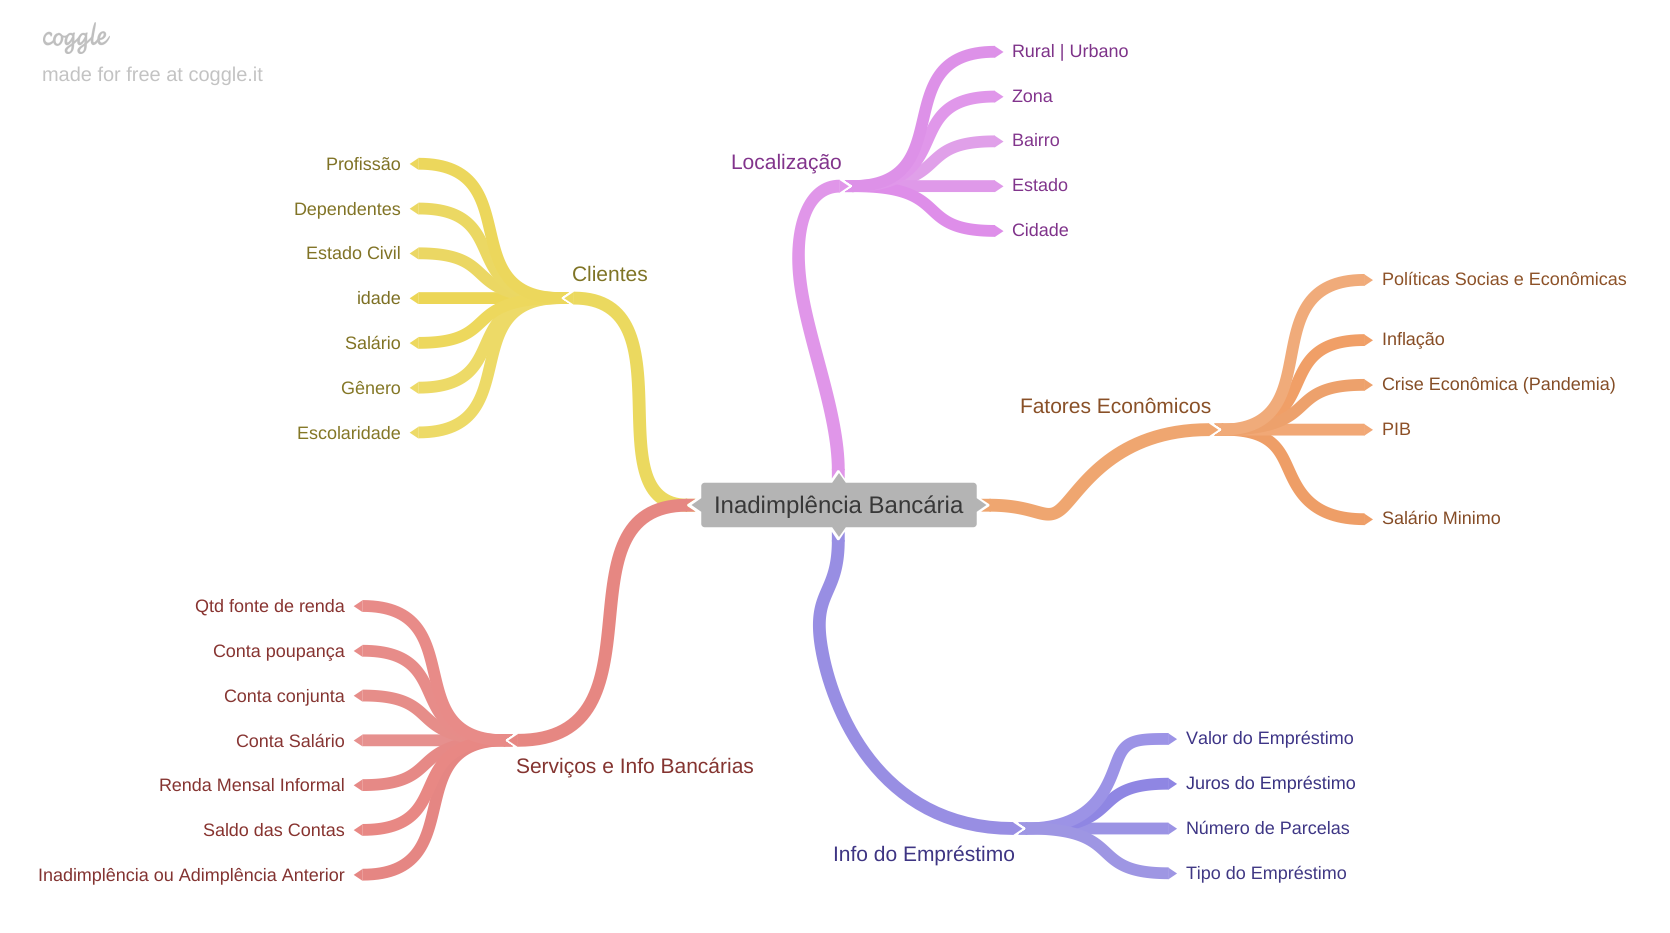

In [23]:
Image(config['imagem']['path'])

### Hipóteses de Informações dos Clientes

1. Mulheres são em média 10% mais ADIMPLENTES.
2. Clientes com Menos de 60 anos são em média 20% mais ADIMPLENTES.
3. Clientes com Dependentes são em média 15% mais ADIMPLENTES.
4. Clientes que são solteiros tem uma taxa percentual maior de INADIMPLÊNCIA que os demais.

### Hipóteses de Informações Bancárias

5. Clientes com conta salário são em média 30% mais ADIMPLENTES.
6. Clientes com conta poupança são em média 10% mais ADIMPLENTES.
7. Clientes que já passaram cheque sem fundo são em média 15% mais INADIMPLENTES.
8. Clientes que tem conta conjunta são em média 10% mais INADIMPLENTES.

### Hipóteses de Informações do Empréstimo

9. Clientes que pegaram empréstimos de mais de RS$20000 tem tendência a ser INADIMPLENTES.

### Hipóteses de Informações de Localização

10. Clientes que moram no Estado RJ E SP tem maior percentual de ADIMPLENTE
do que ES e MG.

## 3.2 Engenharia de variaveis

In [24]:
len(df3['id'].unique())

50390

In [25]:
df3.shape

(50390, 15)

In [26]:
df3['juros_porcentagem'] = df3['juros'] / df3['valor_emprestimo']

# 4.0 EDA UNIVARIADA

In [27]:
df4 = df3.copy()

## 4.1 NUMERICA

In [28]:
num_attributes = df4.select_dtypes(include=['int64', 'float64'])

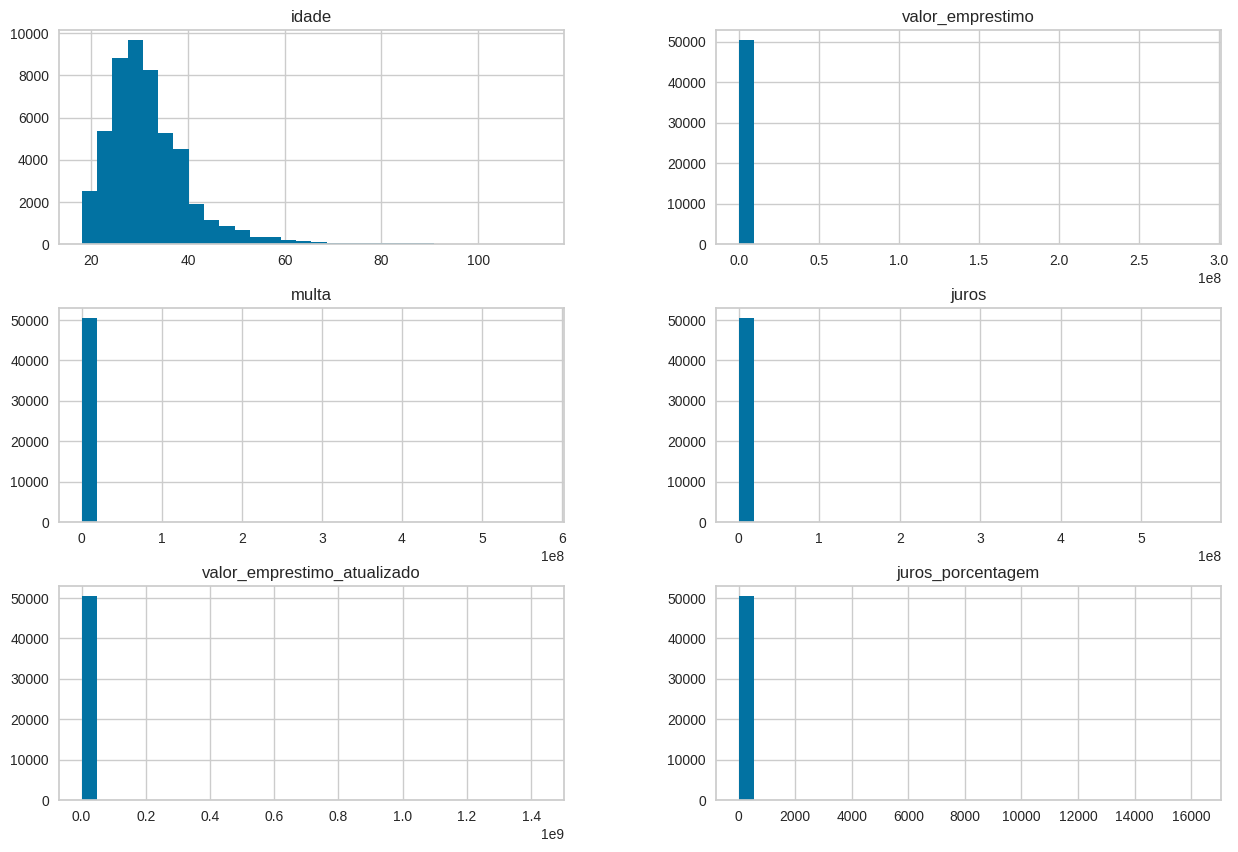

In [29]:
num_attributes.drop('id', axis='columns').hist(bins=30, figsize=(15,10));

### 4.1.1 IDADE

count    50390.000000
mean        31.724529
std          8.565117
min         18.000000
25%         26.000000
50%         30.000000
75%         35.000000
max        113.000000
Name: idade, dtype: float64


Text(0.5, 1.0, 'boxplot')

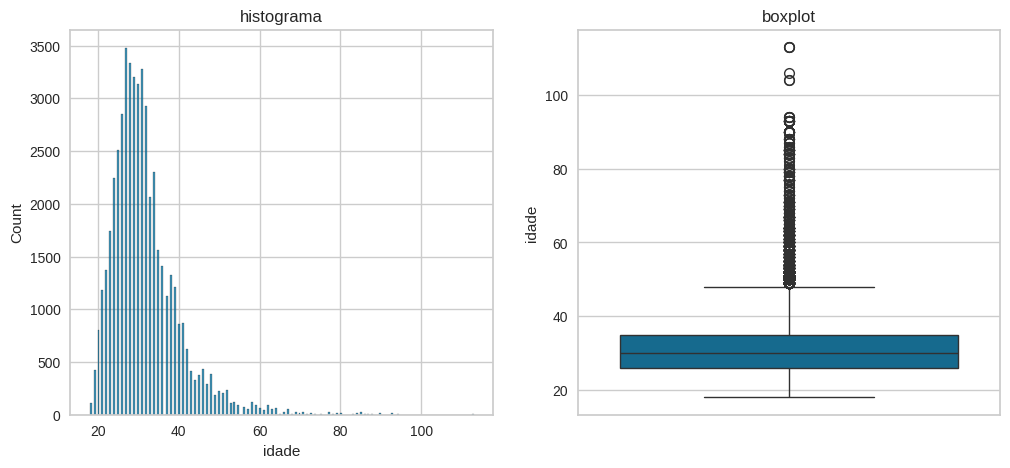

In [30]:
print(df4['idade'].describe())
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.histplot(df4['idade'], ax=axes[0])
axes[0].set_title('histograma')

sns.boxplot(df4['idade'], ax=axes[1])
axes[1].set_title('boxplot')

### 4.1.2 VALOR DO EMPRESTIMO

count    5.039000e+04
mean     5.198887e+04
std      1.588819e+06
min      1.393000e+03
25%      1.622370e+03
50%      2.298035e+03
75%      7.172175e+03
max      2.867894e+08
Name: valor_emprestimo, dtype: float64


Text(0.5, 1.0, 'boxplot')

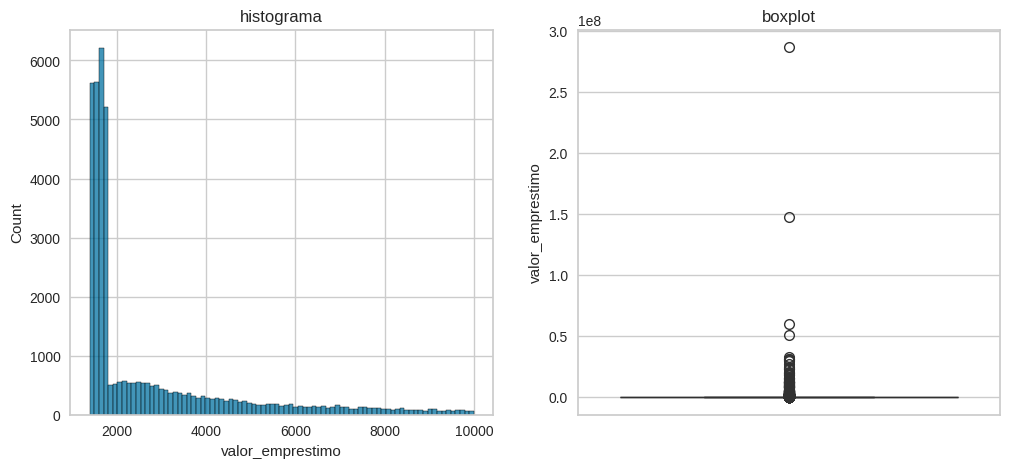

In [31]:
print(df4['valor_emprestimo'].describe())
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.histplot(df4[df4['valor_emprestimo'] < 10000]['valor_emprestimo'], ax=axes[0])
axes[0].set_title('histograma')

sns.boxplot(df4['valor_emprestimo'], ax=axes[1])
axes[1].set_title('boxplot')

### 4.1.3 MULTA

count    5.039000e+04
mean     6.022658e+04
std      2.843941e+06
min      0.000000e+00
25%      1.325675e+02
50%      6.489650e+02
75%      3.600000e+03
max      5.737759e+08
Name: multa, dtype: float64


Text(0.5, 1.0, 'boxplot')

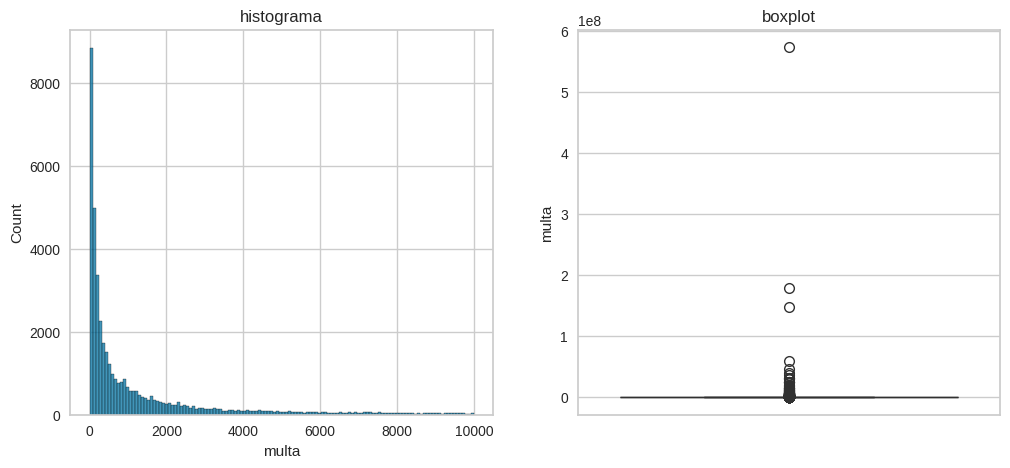

In [32]:
print(df4['multa'].describe())
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.histplot(df4[df4['multa'] < 10000]['multa'], ax=axes[0])
axes[0].set_title('histograma')

sns.boxplot(df4['multa'], ax=axes[1])
axes[1].set_title('boxplot')

### 4.1.4 JUROS

count    5.039000e+04
mean     6.485391e+04
std      2.728170e+06
min      0.000000e+00
25%      2.742725e+02
50%      1.143320e+03
75%      5.545427e+03
max      5.703619e+08
Name: juros, dtype: float64


Text(0.5, 1.0, 'boxplot')

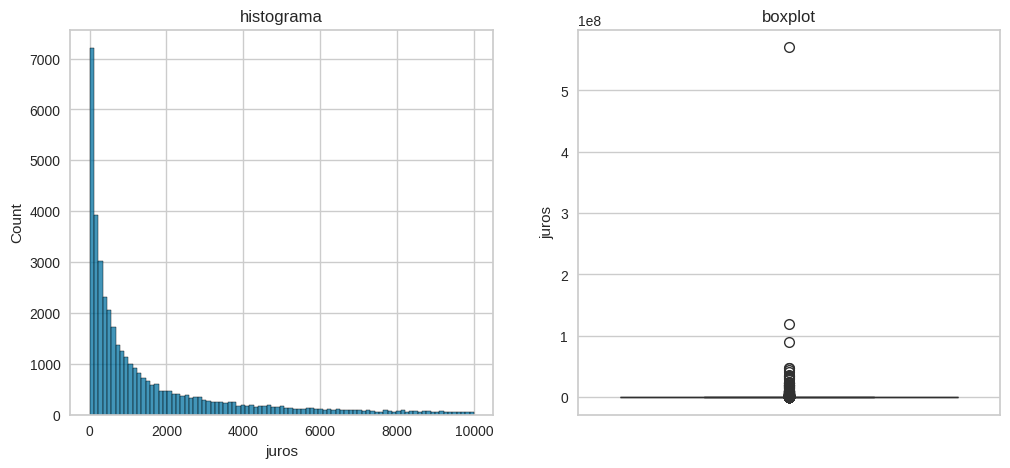

In [33]:
print(df4['juros'].describe())
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.histplot(df4[df4['juros'] < 10000]['juros'], ax=axes[0])
axes[0].set_title('histograma')

sns.boxplot(df4['juros'], ax=axes[1])
axes[1].set_title('boxplot')

### 4.1.5 VOLOR DO EMPRESTIMO ATUALIZADO

count    5.039000e+04
mean     1.770694e+05
std      7.058364e+06
min      1.397040e+03
25%      2.842910e+03
50%      5.652695e+03
75%      1.903061e+04
max      1.430927e+09
Name: valor_emprestimo_atualizado, dtype: float64


Text(0.5, 1.0, 'boxplot')

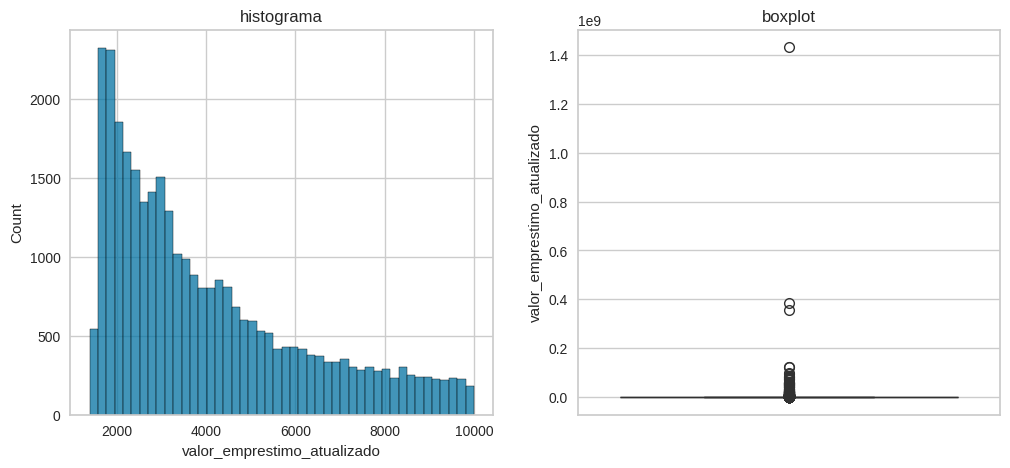

In [34]:
print(df4['valor_emprestimo_atualizado'].describe())
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.histplot(df4[df4['valor_emprestimo_atualizado'] < 10000]['valor_emprestimo_atualizado'], ax=axes[0])
axes[0].set_title('histograma')

sns.boxplot(df4['valor_emprestimo_atualizado'], ax=axes[1])
axes[1].set_title('boxplot')

### 4.1.6 JUROS PORCENTAGEM

count    50390.000000
mean         3.029730
std        105.423189
min          0.000000
25%          0.112590
50%          0.349677
75%          0.848668
max      16248.020882
Name: juros_porcentagem, dtype: float64


Text(0.5, 1.0, 'boxplot')

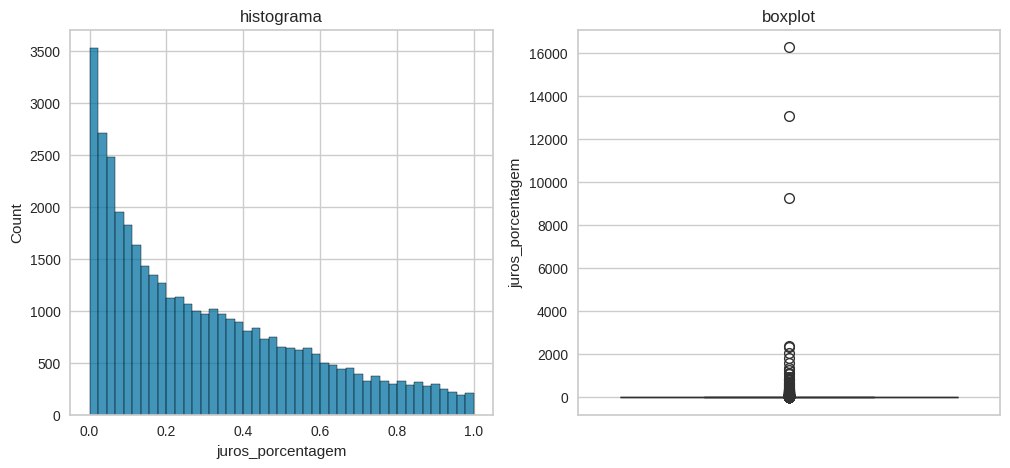

In [35]:
print(df4['juros_porcentagem'].describe())
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.histplot(df4[df4['juros_porcentagem'] < 1]['juros_porcentagem'], ax=axes[0])
axes[0].set_title('histograma')

sns.boxplot(df4['juros_porcentagem'], ax=axes[1])
axes[1].set_title('boxplot')

## 4.2 CATEGORICAS

### 4.2.1 DEPENDENTES

dependentes
N    0.639968
S    0.360032
Name: proportion, dtype: float64


<Axes: xlabel='dependentes', ylabel='count'>

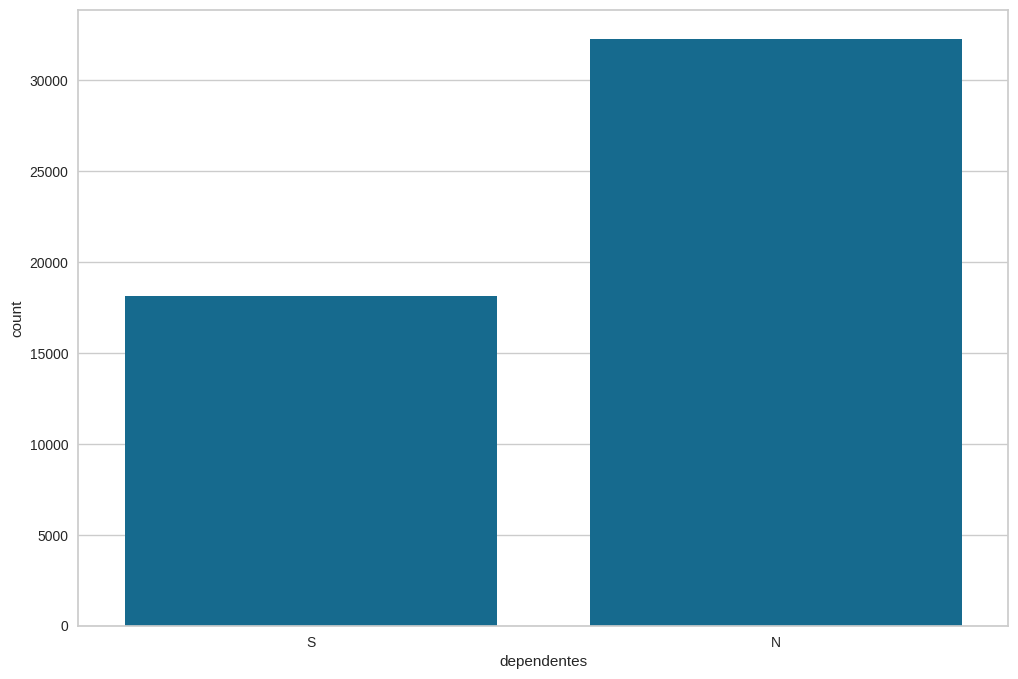

In [36]:
print(df4['dependentes'].value_counts(normalize=True))
sns.countplot(x='dependentes', data=df4)

### 4.2.2 ESTADO CIVIL

estado_civil
solteiro                                  0.547053
casado(a) com comunhao parcial de bens    0.263604
casado(a) com comunhao de bens            0.154098
casado(a) com separacao de bens           0.030959
separado judicialmente                    0.001469
divorciado                                0.001330
viuvo(a)                                  0.000814
outros                                    0.000675
Name: proportion, dtype: float64


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'solteiro'),
  Text(1, 0, 'casado(a) com comunhao de bens'),
  Text(2, 0, 'casado(a) com comunhao parcial de bens'),
  Text(3, 0, 'casado(a) com separacao de bens'),
  Text(4, 0, 'divorciado'),
  Text(5, 0, 'separado judicialmente'),
  Text(6, 0, 'viuvo(a)'),
  Text(7, 0, 'outros')])

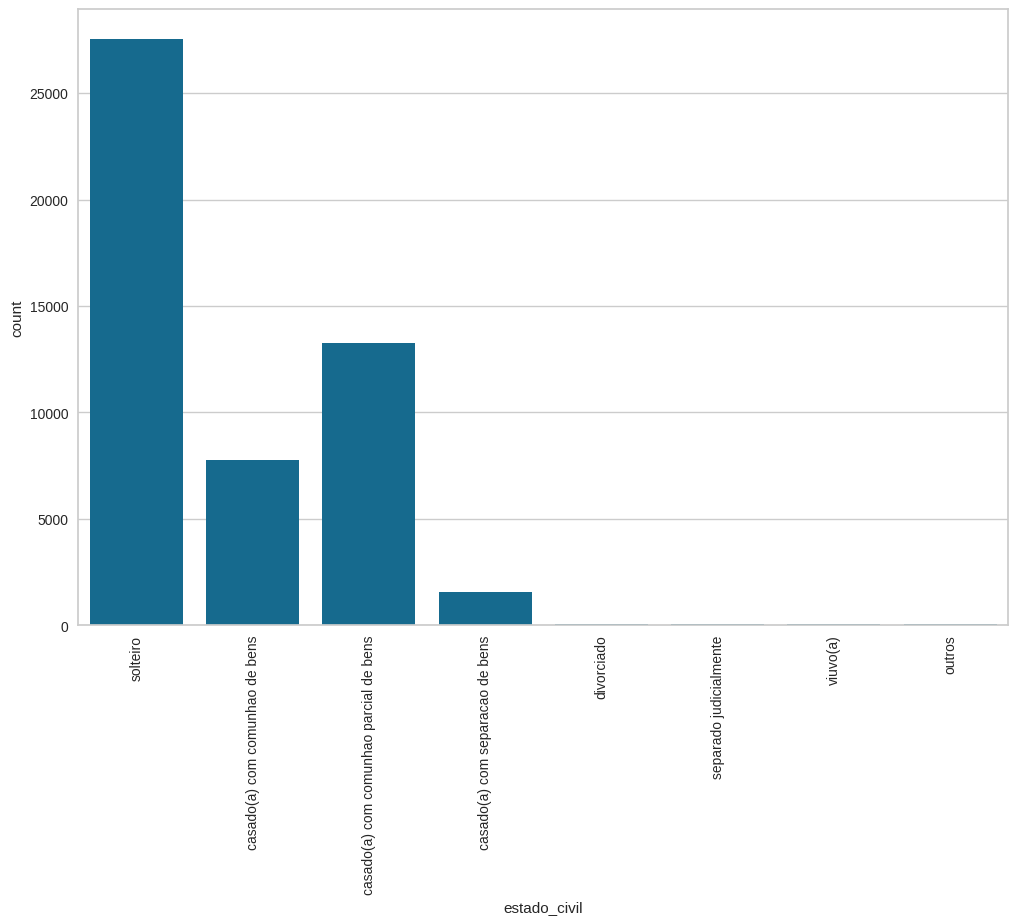

In [37]:
print(df4['estado_civil'].value_counts(normalize=True))
sns.countplot(x='estado_civil', data=df4)
plt.xticks(rotation= 90)

### 4.2.3 CONTA POUPANCA

conta_poupanca
S    0.847986
N    0.152014
Name: proportion, dtype: float64


<Axes: xlabel='conta_poupanca', ylabel='count'>

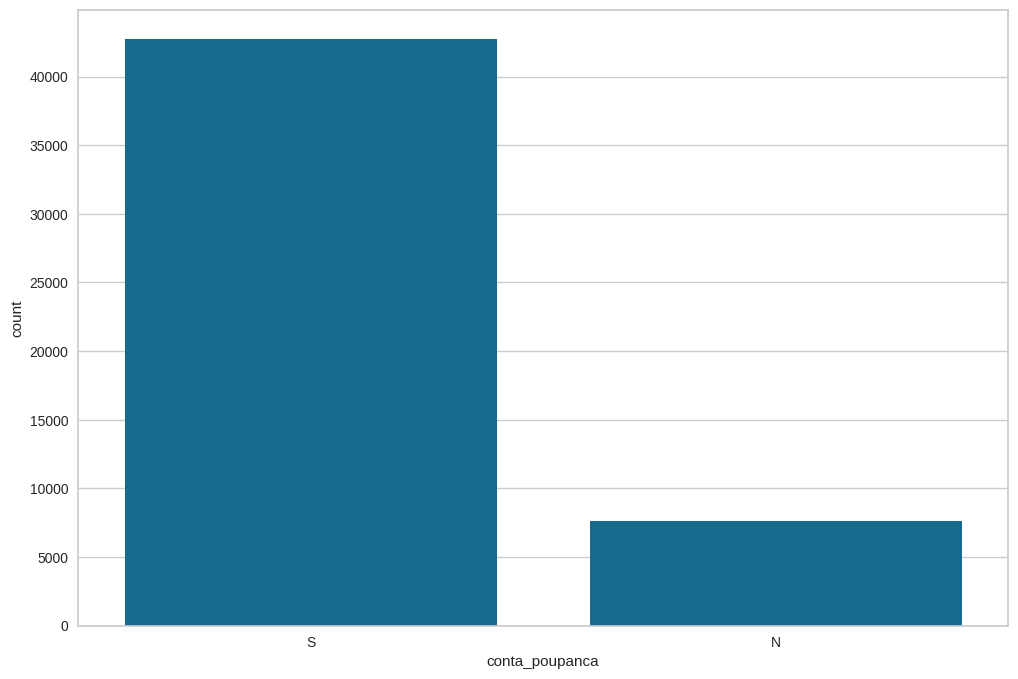

In [38]:
print(df4['conta_poupanca'].value_counts(normalize=True))
sns.countplot(x='conta_poupanca', data=df4)

### 4.2.4 CONTA SALARIO

conta_salario
N    0.976603
S    0.023397
Name: proportion, dtype: float64


<Axes: xlabel='conta_salario', ylabel='count'>

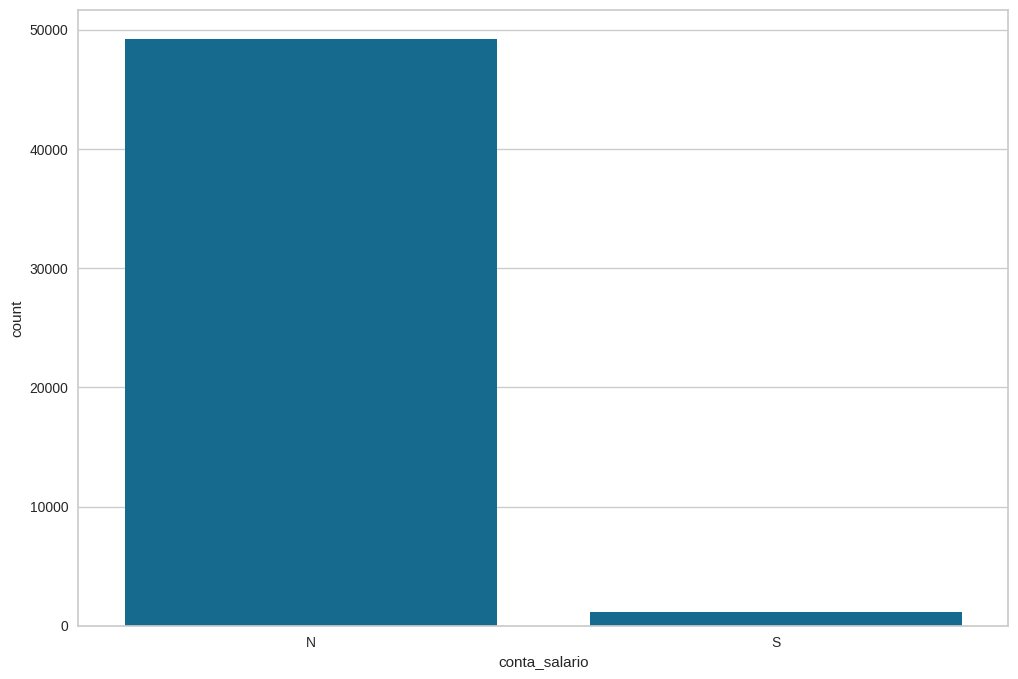

In [39]:
print(df4['conta_salario'].value_counts(normalize=True))
sns.countplot(x='conta_salario', data=df4)

### 4.2.5 CHEQUE SEM FUNDO

cheque_sem_fundo
S    0.769974
N    0.230026
Name: proportion, dtype: float64


<Axes: xlabel='cheque_sem_fundo', ylabel='count'>

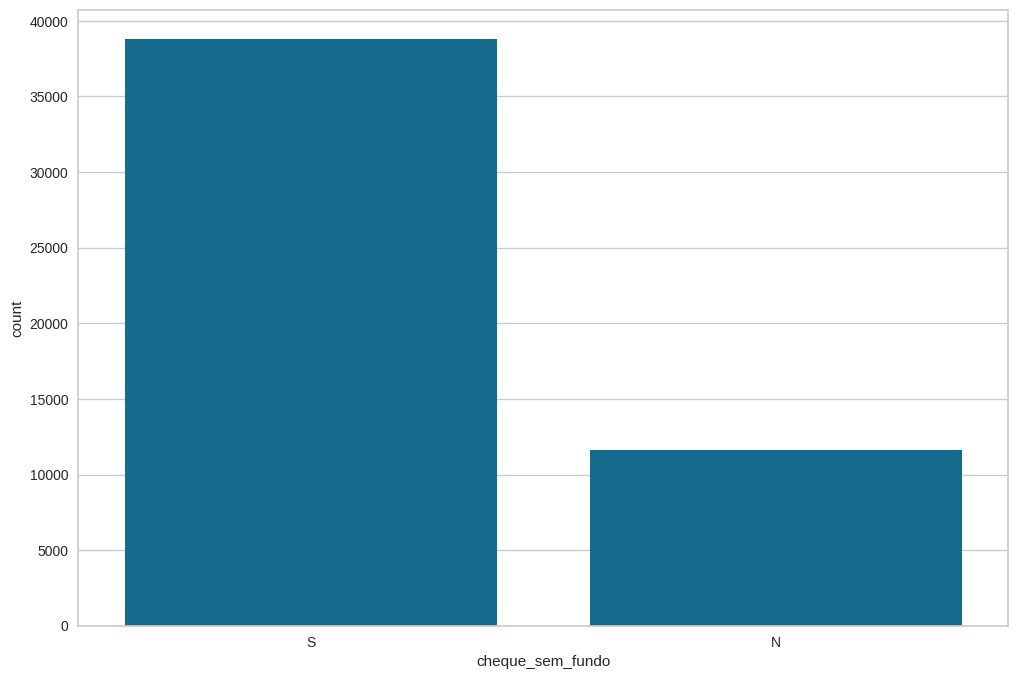

In [40]:
print(df4['cheque_sem_fundo'].value_counts(normalize=True))
sns.countplot(x='cheque_sem_fundo', data=df4)

### 4.2.6 CONTA CONJUNTA

conta_conjunta
N    0.958285
S    0.041715
Name: proportion, dtype: float64


<Axes: xlabel='conta_conjunta', ylabel='count'>

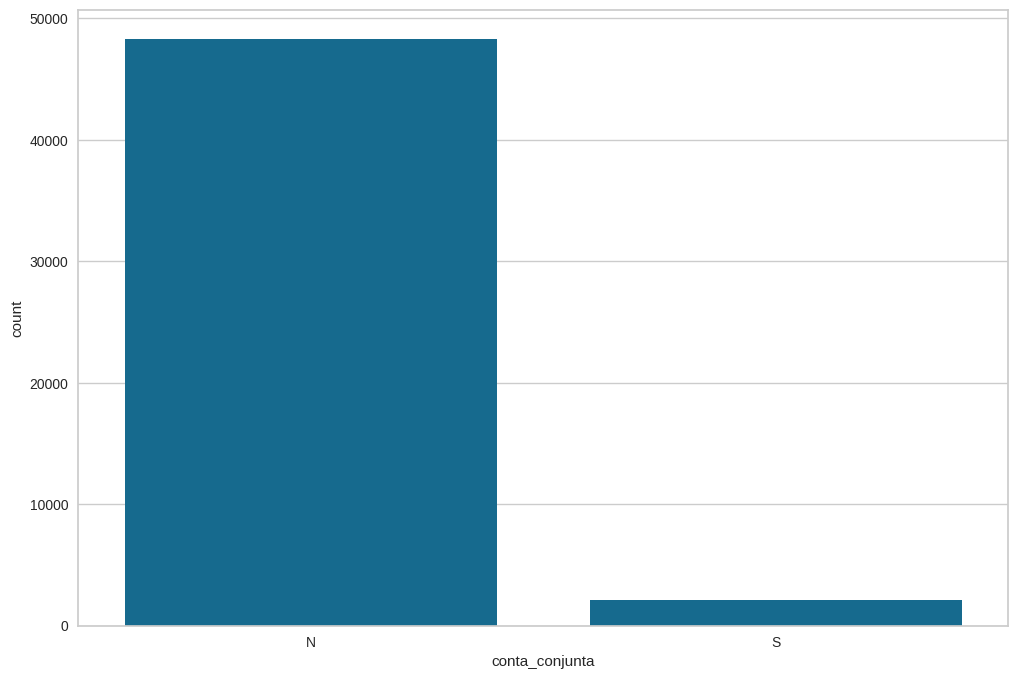

In [41]:
print(df4['conta_conjunta'].value_counts(normalize=True))
sns.countplot(x='conta_conjunta', data=df4)

### 4.2.7 PAGO

pago
sim    0.790891
nao    0.209109
Name: proportion, dtype: float64


<Axes: xlabel='pago', ylabel='count'>

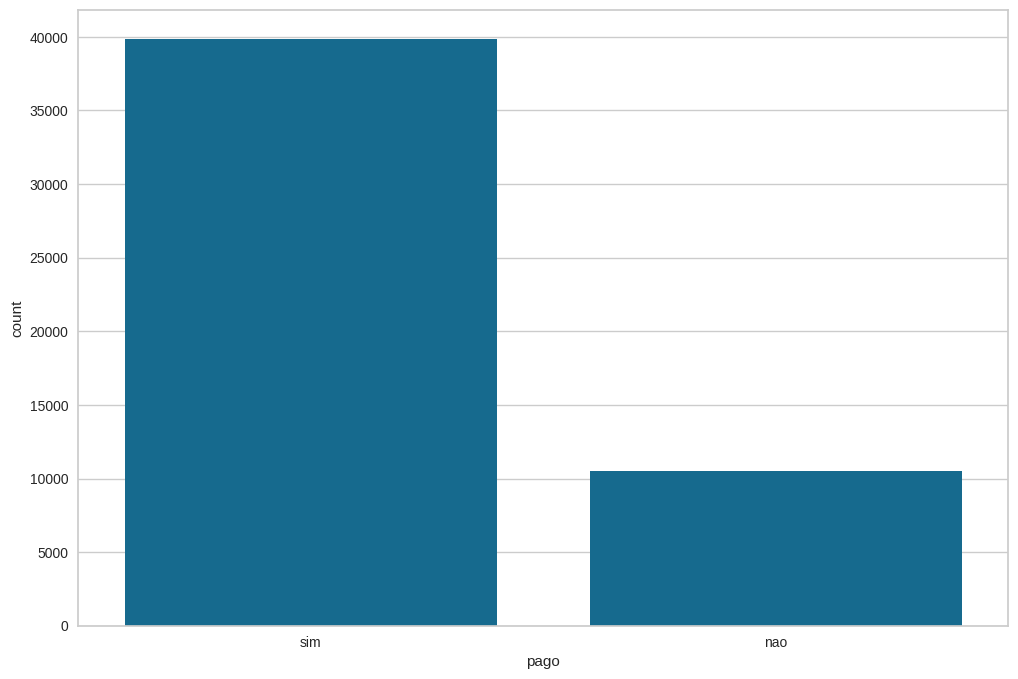

In [42]:
print(df4['pago'].value_counts(normalize=True))
sns.countplot(x='pago', data=df4)

### 4.2.8 GENERO

genero
masculino    0.501667
feminino     0.498333
Name: proportion, dtype: float64


<Axes: xlabel='genero', ylabel='count'>

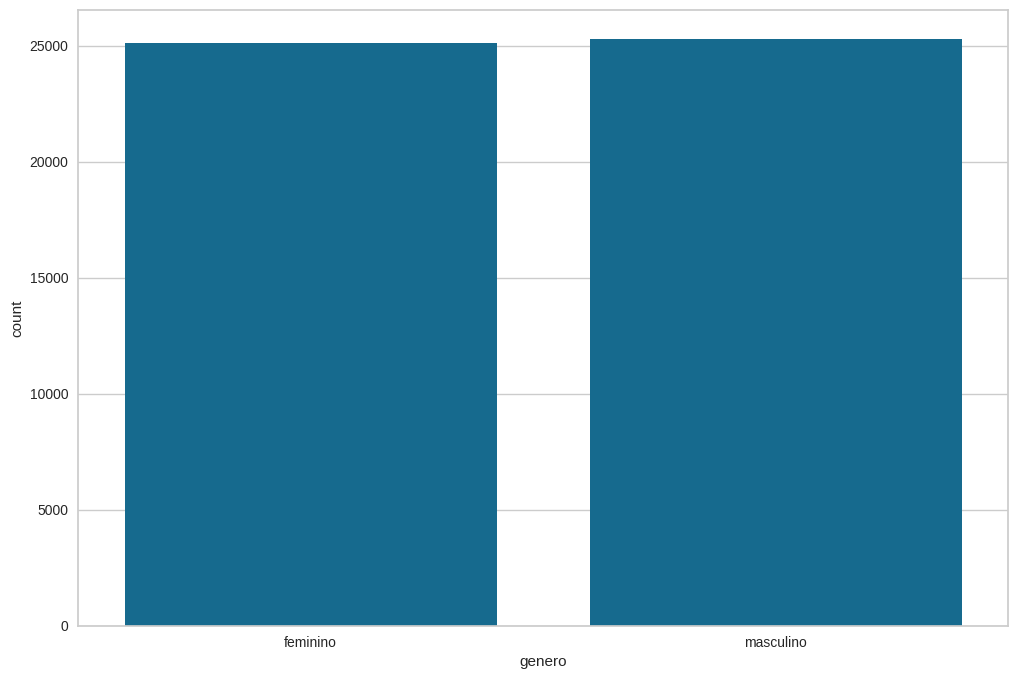

In [43]:
print(df4['genero'].value_counts(normalize=True))
sns.countplot(x='genero', data=df4)

### 4.2.9 ESTADO

estado
minas gerais      0.251340
sao paulo         0.250189
espirito santo    0.249772
rio de janeiro    0.248700
Name: proportion, dtype: float64


<Axes: xlabel='estado', ylabel='count'>

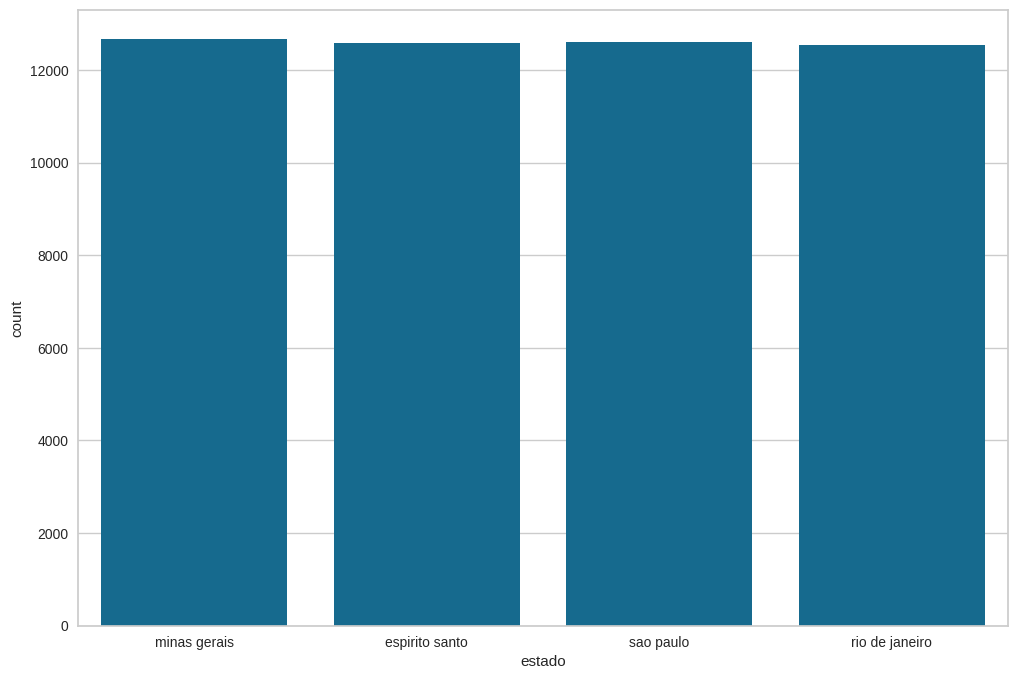

In [44]:
print(df4['estado'].value_counts(normalize=True))
sns.countplot(x='estado', data=df4)

# 5.0 CLEAN OUTLIERS

In [45]:
df5 = df4.copy()

In [46]:
df5['pago'].value_counts(normalize=True)

pago
sim    0.790891
nao    0.209109
Name: proportion, dtype: float64

In [47]:
len(df5[df5['valor_emprestimo'] > 5_000_000]) /len(df5)

0.0015479261758285373

In [48]:
len(df5[df5['juros_porcentagem'] < 0.01]) / len(df5)

0.03464973208970034

In [49]:
df5 = df5[df5['valor_emprestimo'] < 5_000_000].copy()
df5 = df5[df5['juros_porcentagem'] > 0.01].copy()


In [50]:
df5['pago'].value_counts(normalize=True)

pago
sim    0.787073
nao    0.212927
Name: proportion, dtype: float64

In [51]:
df5.to_csv(config['data']['trusted_path'], index=False)

# 6.0 EDA BIVARIADA

In [52]:
df6 = pd.read_csv(config['data']['trusted_path'])

## 6.1 GENERO Mulheres são em média 10% mais ADIMPLENTES.(FALSO)

pago,nao,sim
genero,,
feminino,5220,18992
masculino,5121,19233


pago,nao,sim
genero,,
feminino,0.215596,0.784404
masculino,0.210273,0.789727


<Axes: xlabel='genero'>

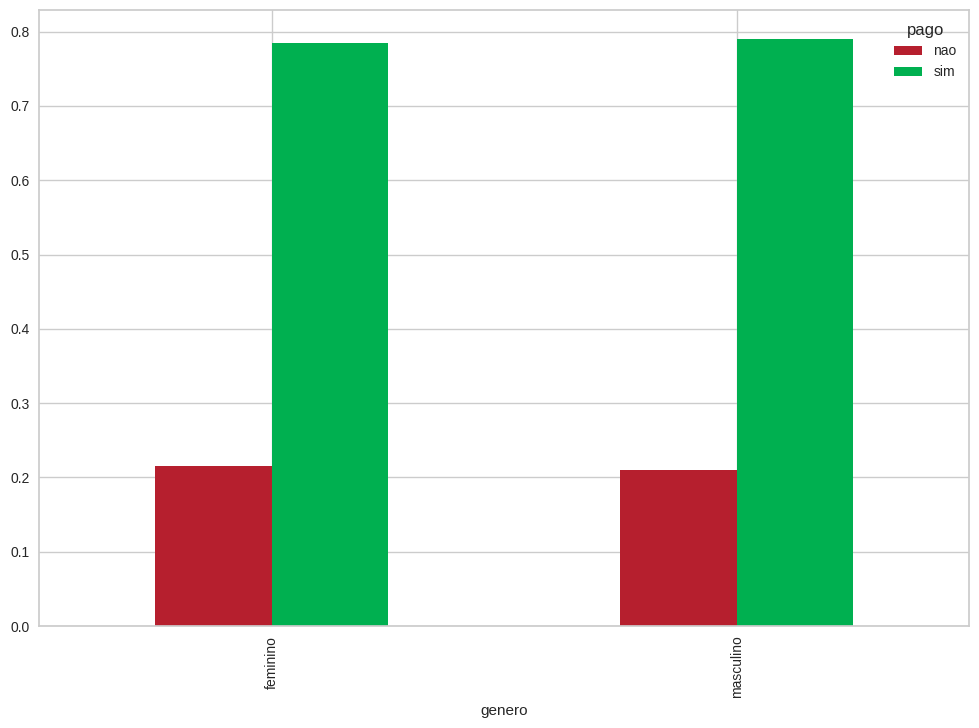

In [53]:
display(pd.crosstab(df6['genero'], df6['pago']))

display(pd.crosstab(df6['genero'], df6['pago'], normalize='index'))

display(pd.crosstab(df6['genero'], df6['pago'], normalize='index').plot(kind='bar', color={'nao': '#b61f2e', 'sim':'#00b050'}))


## 6.2 IDADE Clientes com Menos de 60 anos são em média 20% mais ADIMPLENTES.(FALSO)

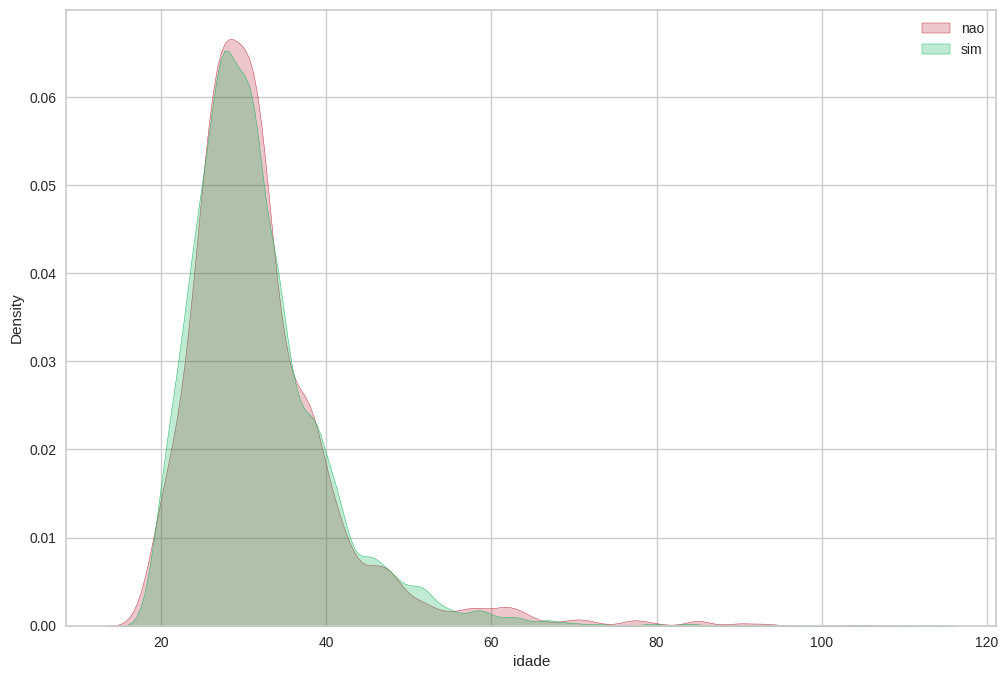

In [54]:
sns.kdeplot(df6[df6['pago'] == 'nao']['idade'], label= 'nao', fill=True, color='#b61f2e')
sns.kdeplot(df6[df6['pago'] == 'sim']['idade'], label= 'sim', fill=True, color='#00b050')
plt.legend();

pago,nao,sim
idade_bined,,
"(18, 38]",8715,32015
"(38, 58]",1345,5649
"(58, 78]",193,408
"(78, 98]",46,80


pago,nao,sim
idade_bined,,
"(18, 38]",0.213970,0.786030
"(38, 58]",0.192308,0.807692
"(58, 78]",0.321131,0.678869
"(78, 98]",0.365079,0.634921


<Axes: xlabel='idade_bined'>

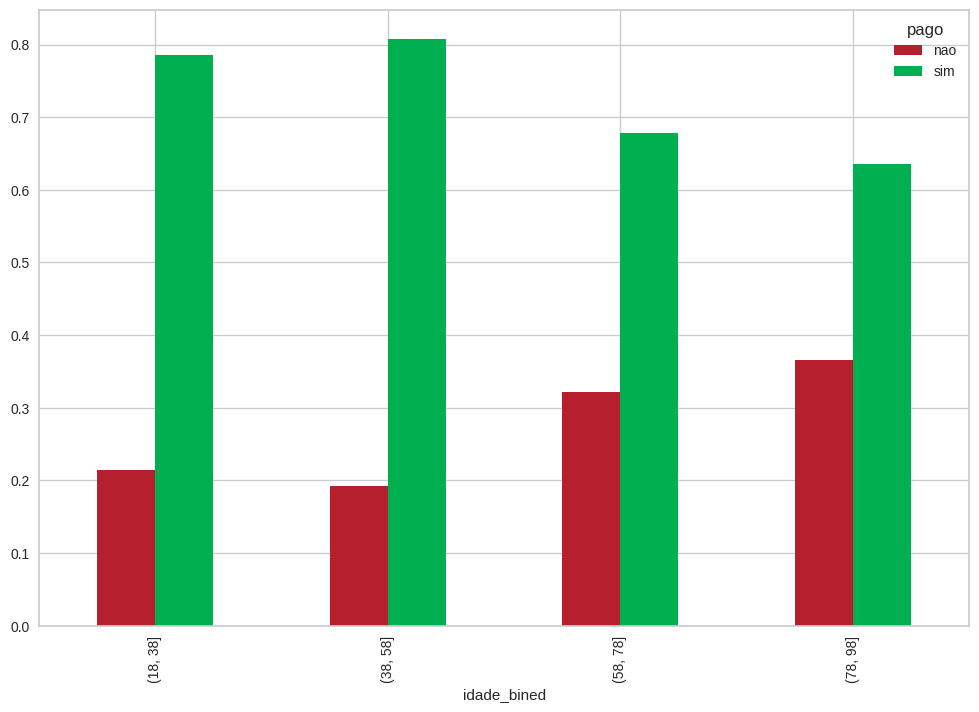

In [55]:
bins = list(np.arange(18,113,20))
aux = df6.copy()

aux['idade_bined'] = pd.cut(aux['idade'],bins = bins)

display(pd.crosstab(aux['idade_bined'], aux['pago']))

display(pd.crosstab(aux['idade_bined'], aux['pago'], normalize='index'))

display(pd.crosstab(aux['idade_bined'], aux['pago'], normalize='index').plot(kind='bar', color={'nao': '#b61f2e', 'sim':'#00b050'}))


## 6.3 DEPENDENTES Clientes com Dependentes são em média 15% mais ADIMPLENTES.(VERDADEIRA)

pago,nao,sim
dependentes,,
N,8661,22568
S,1680,15657


pago,nao,sim
dependentes,,
N,0.277338,0.722662
S,0.096903,0.903097


<Axes: xlabel='dependentes'>

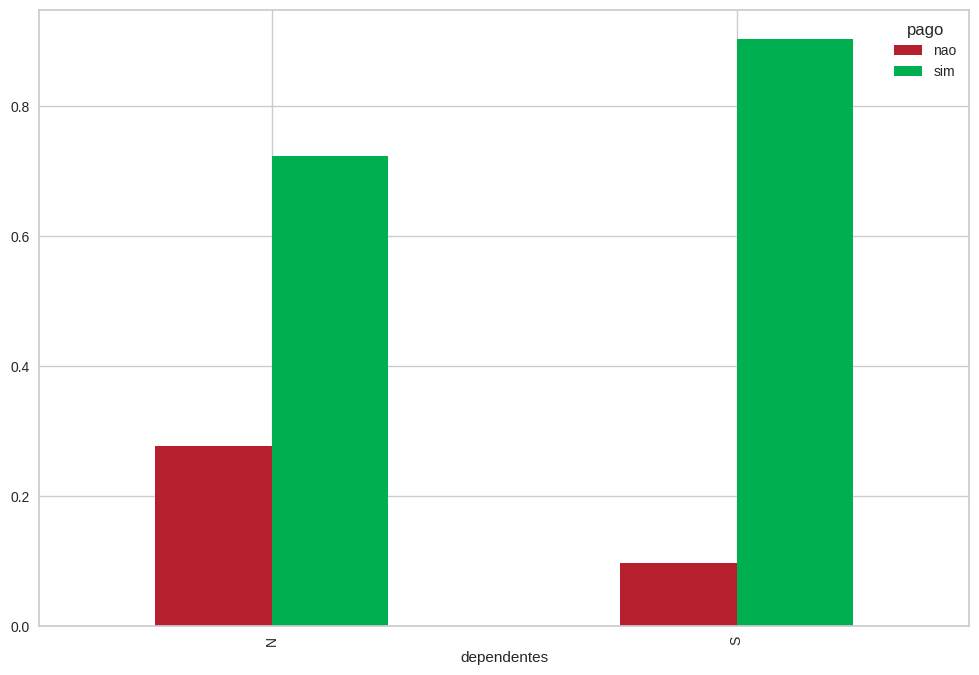

In [56]:
display(pd.crosstab(df6['dependentes'], df6['pago']))

display(pd.crosstab(df6['dependentes'], df6['pago'], normalize='index'))

display(pd.crosstab(df6['dependentes'], df6['pago'], normalize='index').plot(kind='bar', color={'nao': '#b61f2e', 'sim':'#00b050'}))


## 6.4 ESTADO CIVIL Clientes que são solteiros tem uma taxa percentual maior de INADIMPLÊNCIA que os demais. (FALSO)

pago,nao,sim
estado_civil,,
casado(a) com comunhao de bens,1790,5825
casado(a) com comunhao parcial de bens,5112,8003
casado(a) com separacao de bens,401,1105
divorciado,6,56
outros,27,7
separado judicialmente,33,41
solteiro,2949,23170
viuvo(a),23,18


pago,nao,sim
estado_civil,,
casado(a) com comunhao de bens,0.235062,0.764938
casado(a) com comunhao parcial de bens,0.389783,0.610217
casado(a) com separacao de bens,0.266268,0.733732
divorciado,0.096774,0.903226
outros,0.794118,0.205882
separado judicialmente,0.445946,0.554054
solteiro,0.112906,0.887094
viuvo(a),0.560976,0.439024


<Axes: xlabel='estado_civil'>

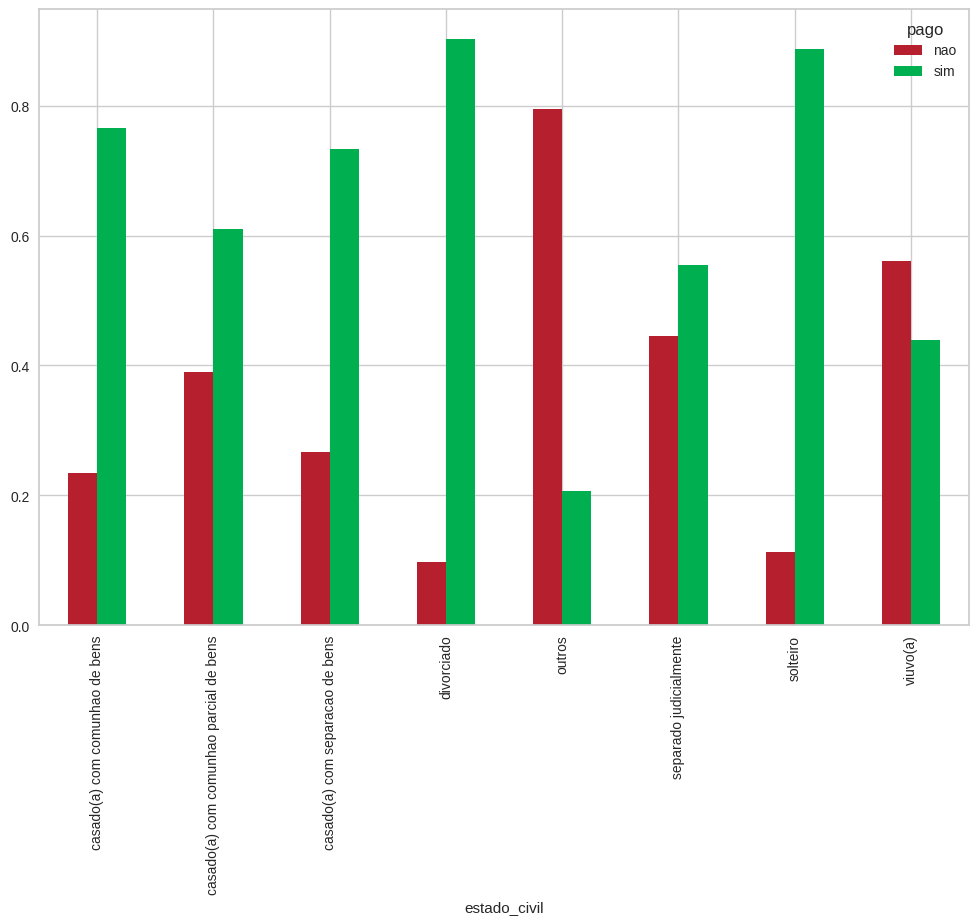

In [57]:
display(pd.crosstab(df6['estado_civil'], df6['pago']))

display(pd.crosstab(df6['estado_civil'], df6['pago'], normalize='index'))

display(pd.crosstab(df6['estado_civil'], df6['pago'], normalize='index').plot(kind='bar', color={'nao': '#b61f2e', 'sim':'#00b050'}))


## 6.5 CONTA SALARIO Clientes com conta salário são em média 30% mais ADIMPLENTES.(FALSO)

pago,nao,sim
conta_salario,,
N,10030,37403
S,311,822


pago,nao,sim
conta_salario,,
N,0.211456,0.788544
S,0.274492,0.725508


<Axes: xlabel='conta_salario'>

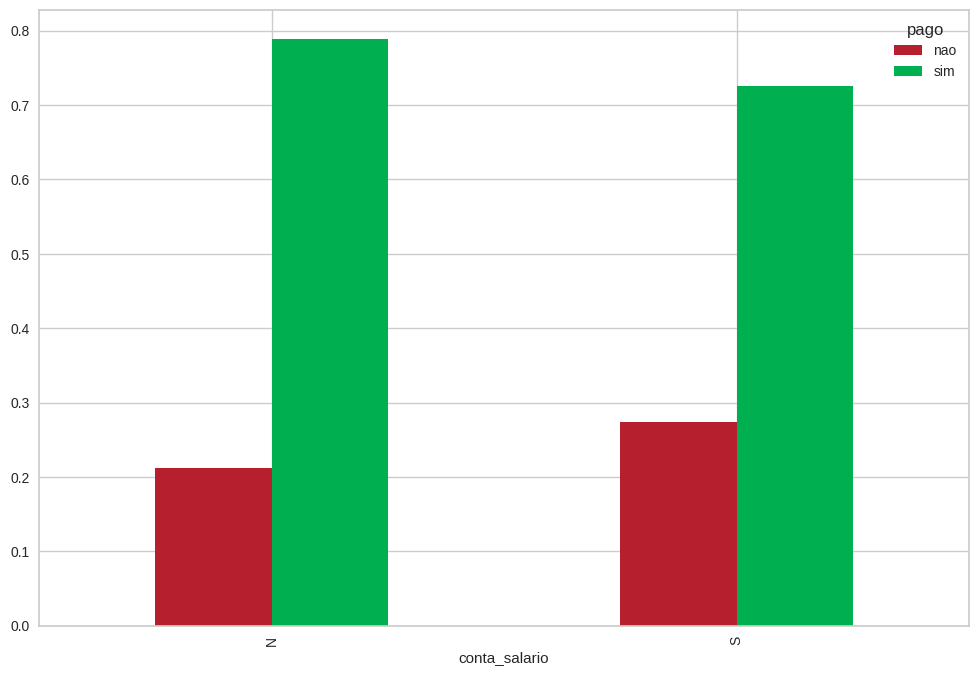

In [58]:
display(pd.crosstab(df6['conta_salario'], df6['pago']))

display(pd.crosstab(df6['conta_salario'], df6['pago'], normalize='index'))

display(pd.crosstab(df6['conta_salario'], df6['pago'], normalize='index').plot(kind='bar', color={'nao': '#b61f2e', 'sim':'#00b050'}))


## 6.6 CONTA POUPANCA Clientes com conta poupança são em média 10% mais ADIMPLENTES.(FALSO)

pago,nao,sim
conta_poupanca,,
N,1847,5648
S,8494,32577


pago,nao,sim
conta_poupanca,,
N,0.246431,0.753569
S,0.206813,0.793187


<Axes: xlabel='conta_poupanca'>

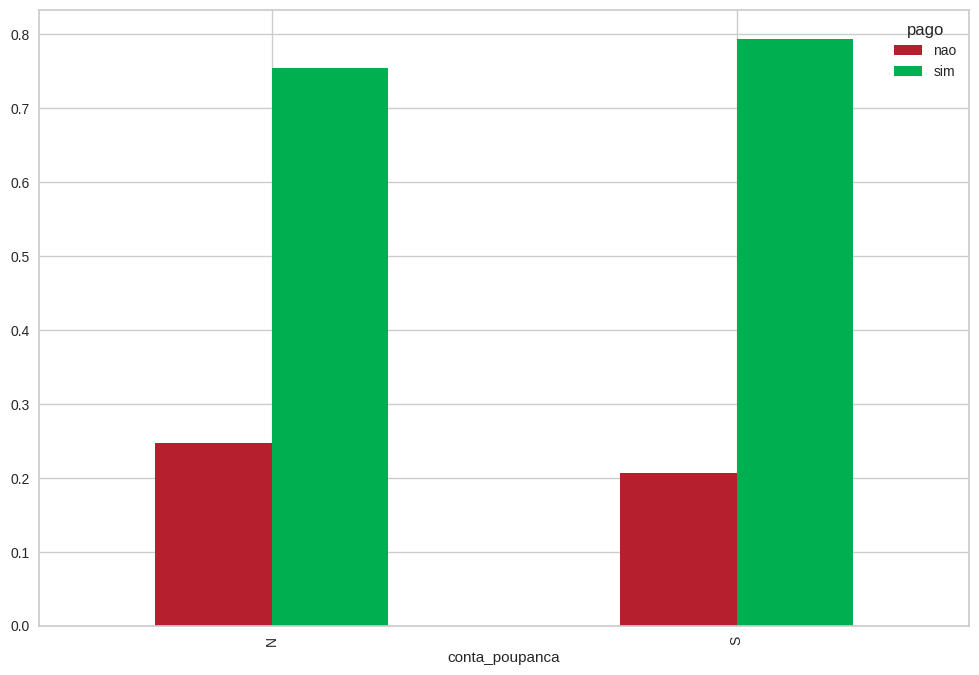

In [59]:
display(pd.crosstab(df6['conta_poupanca'], df6['pago']))

display(pd.crosstab(df6['conta_poupanca'], df6['pago'], normalize='index'))

display(pd.crosstab(df6['conta_poupanca'], df6['pago'], normalize='index').plot(kind='bar', color={'nao': '#b61f2e', 'sim':'#00b050'}))


## 6.7 CHEQUE SEM FUNDO Clientes que já passaram cheque sem fundo são em média 15% mais INADIMPLENTES.(VERDADEIRO)

pago,nao,sim
cheque_sem_fundo,,
N,1051,9958
S,9290,28267


pago,nao,sim
cheque_sem_fundo,,
N,0.095467,0.904533
S,0.247357,0.752643


<Axes: xlabel='cheque_sem_fundo'>

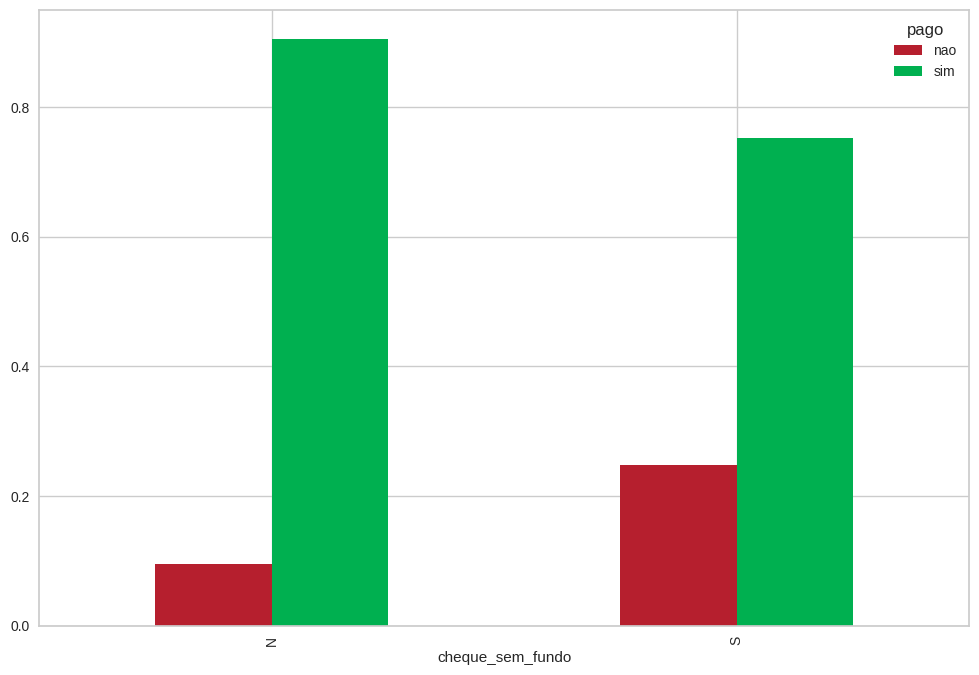

In [60]:
display(pd.crosstab(df6['cheque_sem_fundo'], df6['pago']))

display(pd.crosstab(df6['cheque_sem_fundo'], df6['pago'], normalize='index'))

display(pd.crosstab(df6['cheque_sem_fundo'], df6['pago'], normalize='index').plot(kind='bar', color={'nao': '#b61f2e', 'sim':'#00b050'}))


## 6.8 CONTA CONJUNTA Clientes que tem conta conjunta são em média 10% mais INADIMPLENTES. (FALSO)

pago,nao,sim
conta_conjunta,,
N,10085,36489
S,256,1736


pago,nao,sim
conta_conjunta,,
N,0.216537,0.783463
S,0.128514,0.871486


<Axes: xlabel='conta_conjunta'>

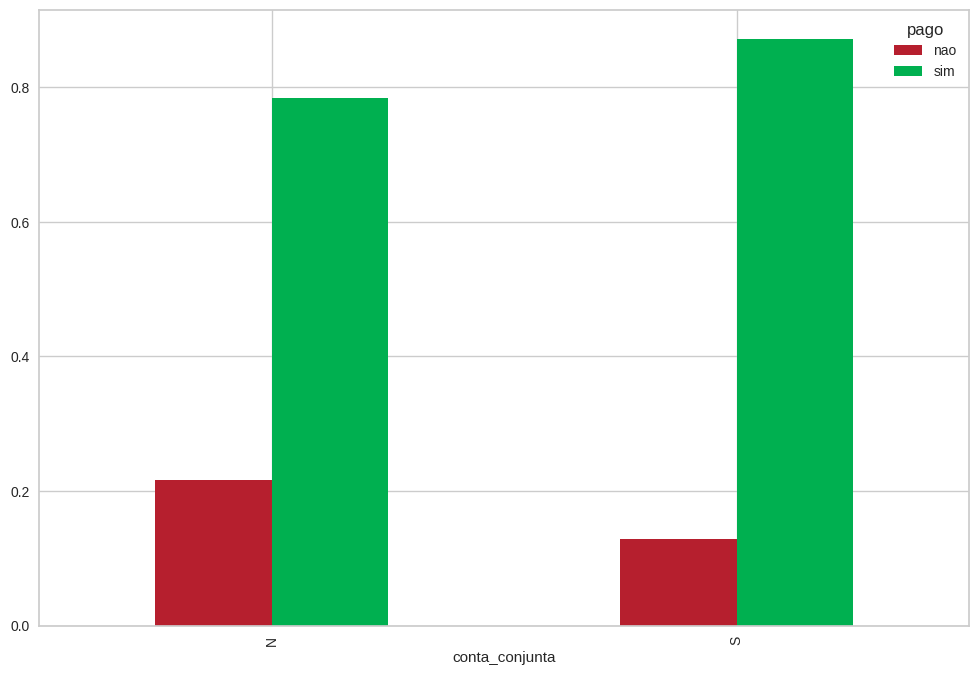

In [61]:
display(pd.crosstab(df6['conta_conjunta'], df6['pago']))

display(pd.crosstab(df6['conta_conjunta'], df6['pago'], normalize='index'))

display(pd.crosstab(df6['conta_conjunta'], df6['pago'], normalize='index').plot(kind='bar', color={'nao': '#b61f2e', 'sim':'#00b050'}))


## 6.9 EMPRESTIMO Clientes que pegaram empréstimos de mais de RS$20000 tem tendência a ser INADIMPLENTES.(VERDADEIRA)

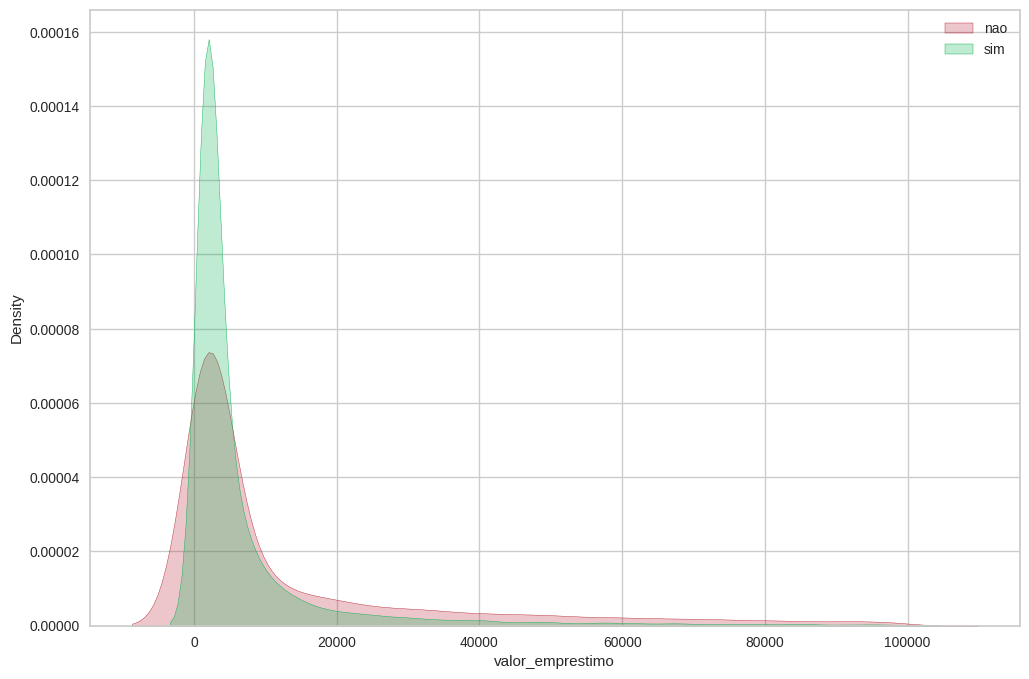

In [62]:
aux = df6[df6['valor_emprestimo'] < 100_000]

sns.kdeplot(aux[aux['pago'] == 'nao']['valor_emprestimo'], label= 'nao', fill=True, color='#b61f2e')
sns.kdeplot(aux[aux['pago'] == 'sim']['valor_emprestimo'], label= 'sim', fill=True, color='#00b050')
plt.legend();

## 6.10 ESTADO Clientes que moram no Estado RJ E SP tem maior percentual de ADIMPLENTE do que ES e MG.(FALSO)

pago,nao,sim
estado,,
espirito santo,2597,9550
minas gerais,2590,9612
rio de janeiro,2592,9483
sao paulo,2562,9580


pago,nao,sim
estado,,
espirito santo,0.213798,0.786202
minas gerais,0.212260,0.787740
rio de janeiro,0.214658,0.785342
sao paulo,0.211003,0.788997


<Axes: xlabel='estado'>

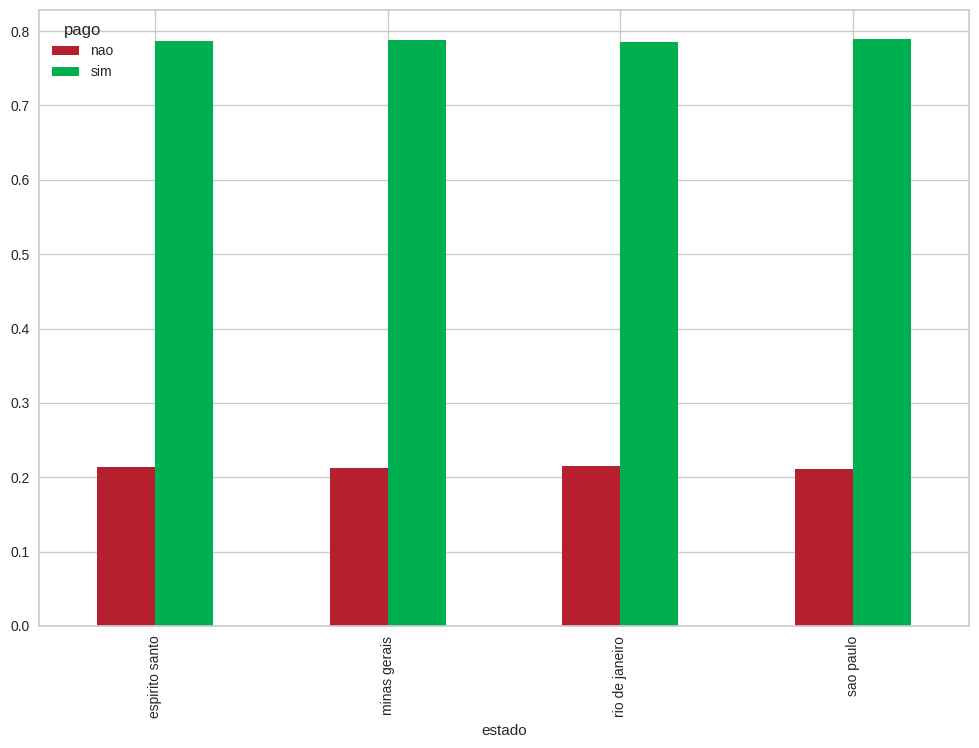

In [63]:
display(pd.crosstab(df6['estado'], df6['pago']))

display(pd.crosstab(df6['estado'], df6['pago'], normalize='index'))

display(pd.crosstab(df6['estado'], df6['pago'], normalize='index').plot(kind='bar', color={'nao': '#b61f2e', 'sim':'#00b050'}))


# 7.0 ANALISE DE CORRELAÇÃO

In [64]:
df7 = df6.copy()

## 7.1 NUMERICAS X NUMERICAS

In [65]:
num_attributes = df7.select_dtypes(include=['int64', 'float64'])
num_attributes = num_attributes.drop('id', axis='columns')

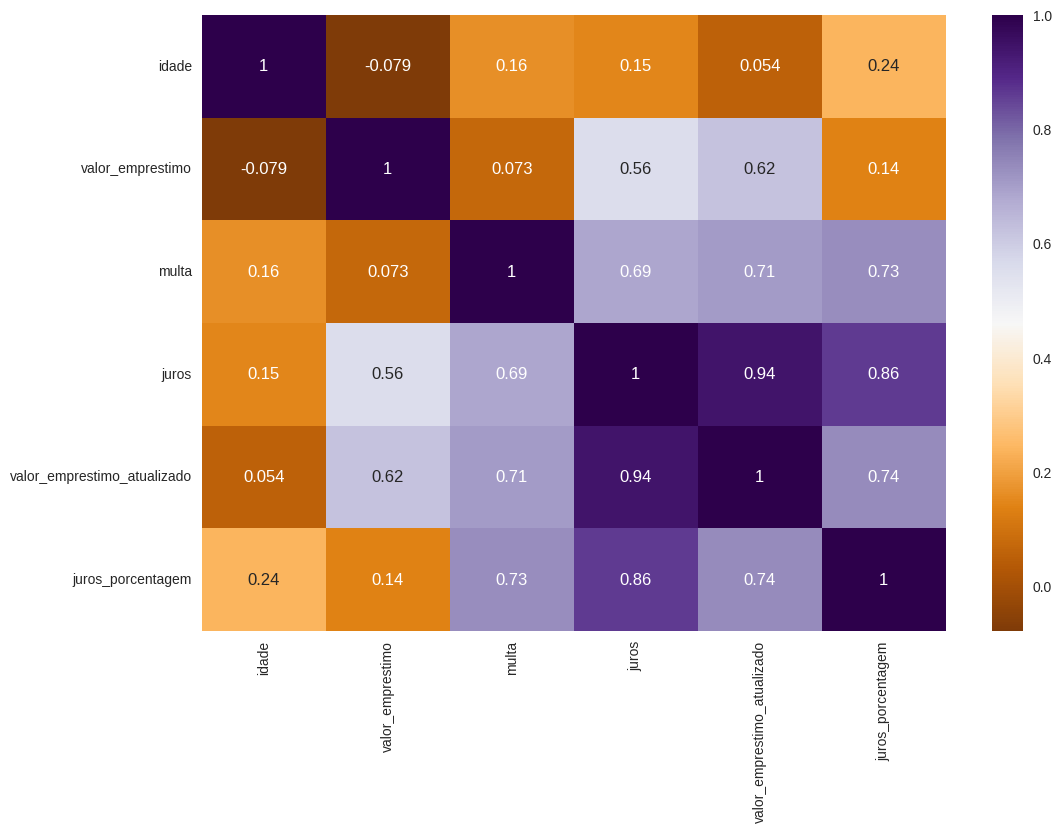

In [66]:
sns.heatmap(num_attributes.corr('spearman'), cmap='PuOr', annot=True);

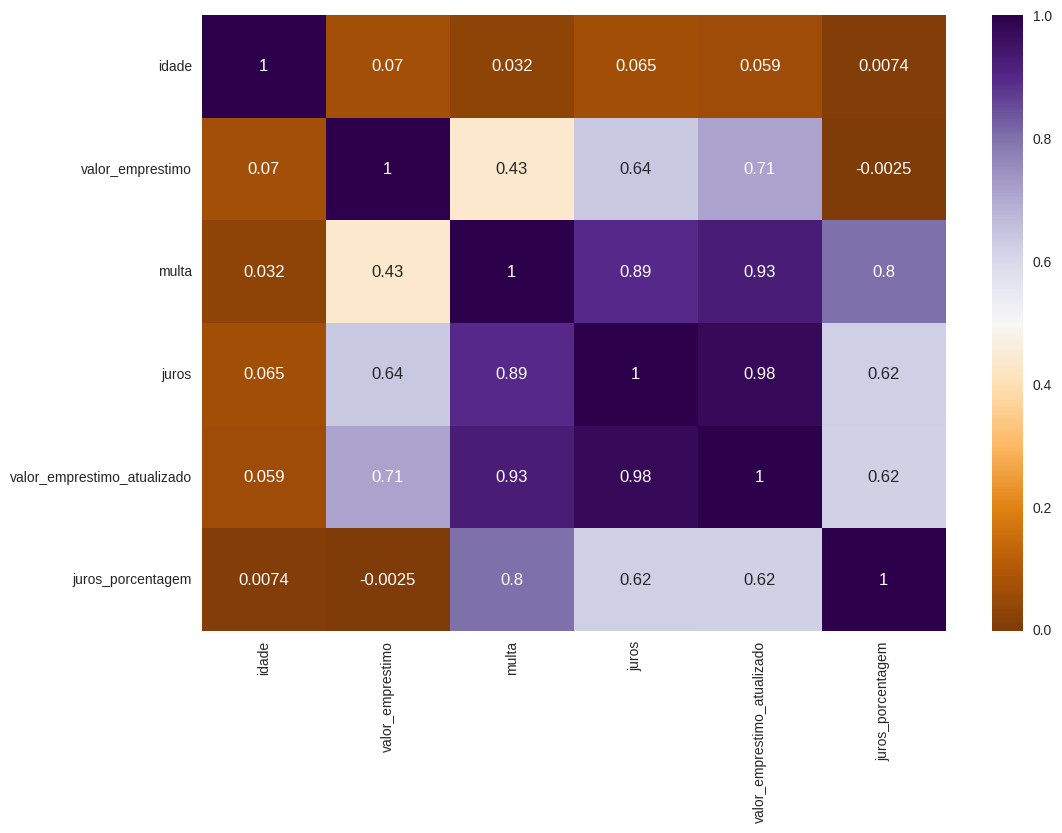

In [67]:
sns.heatmap(num_attributes.corr('pearson'), cmap='PuOr', annot=True);

## 7.2 CATEGORICAS X CATEGORICAS

In [68]:
cat_attributes = df7.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

cat_attributes_list = cat_attributes.columns.tolist()

corr_dict = {}

for i in range(len(cat_attributes_list)):
    corr_list = []

    for j in range(len(cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]

        # correlation
        confusion_matrix = pd.crosstab(cat_attributes[ref], cat_attributes[feat])
        corr = cramers_v(confusion_matrix.values)

        #append a list
        corr_list.append(corr)

    corr_dict[ref] = corr_list


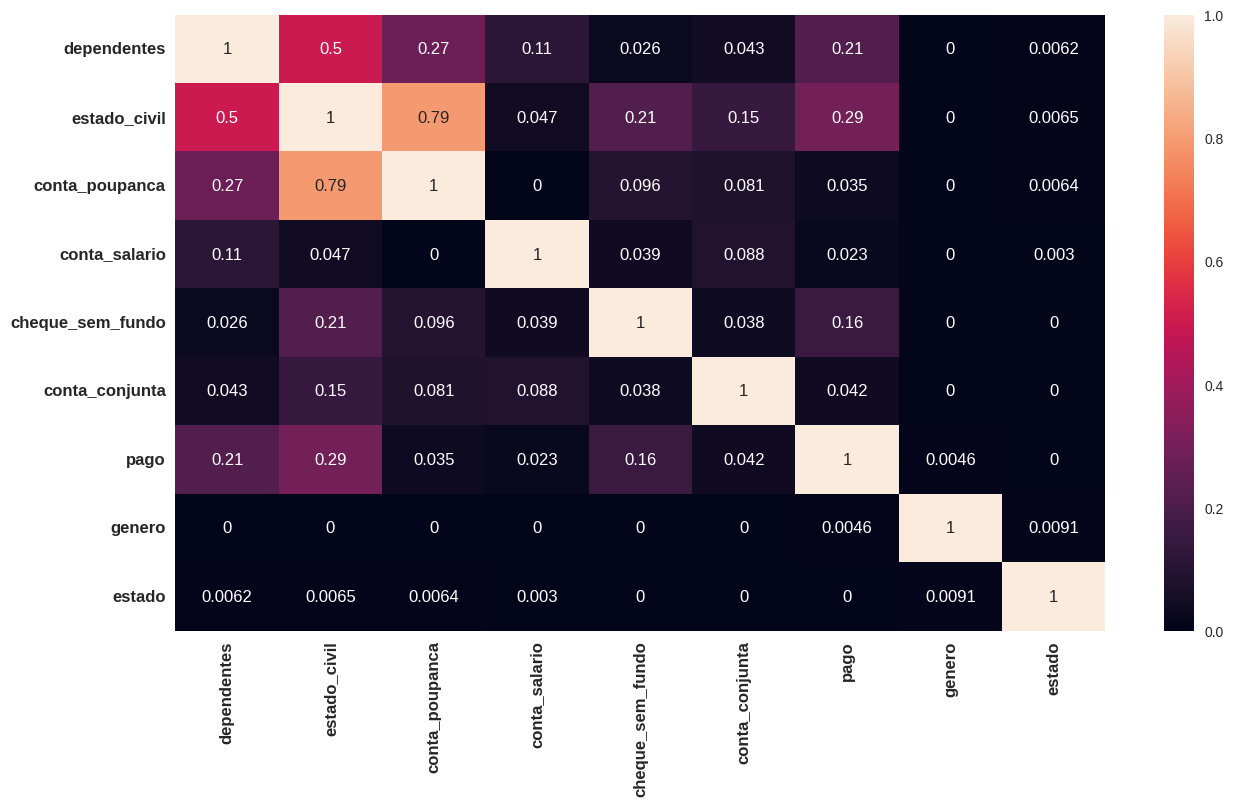

In [69]:
d = pd.DataFrame(corr_dict)

d = d.set_index(d.columns)

plt.figure(figsize=(15,8))
sns.heatmap(d, annot=True)

plt.xticks(rotation=90, fontsize=12, weight='bold')
plt.yticks(rotation=360, fontsize=12, weight='bold');

# 8.0 SPLIT TREINO TESTE E VALIDACAO

In [70]:
df8 = pd.read_csv(config['data']['trusted_path'])

In [71]:
def label_pago(x):
    if x == 'sim':
        return 0
    else:
        return 1

In [72]:
df8['pago'] = df8['pago'].apply(label_pago)

In [73]:
train_set, test_set = train_test_split(df8, test_size=config['split']['teste_size'], random_state=config['split']['seed'], stratify=df8['pago'])

In [74]:
print(len(train_set))
print(len(test_set))

38852
9714


In [75]:
train_set.to_csv(config['data']['train_path'], index=False)
test_set.to_csv(config['data']['test_path'], index=False)


# 9.0 FEATURE SELECTION

In [76]:
df9 = pd.read_csv(config['data']['train_path']).drop(['id','multa', 'juros', 'valor_emprestimo_atualizado', 'juros_porcentagem'], axis='columns').copy()

## 9.1 LOGISTIC REGRESSION

In [83]:
columns_select = ['dependentes', 'estado_civil', 'idade', 'conta_conjunta', 'cheque_sem_fundo', 'valor_emprestimo', 'pago']

df9_lr = df9[columns_select].copy()

### 9.1.1 SELECT VARIABLES P VALUE

In [84]:
ce_rare = RareLabelEncoder(n_categories=5, tol=0.05, variables=['estado_civil'], replace_with='outros')
ce_rare.fit(df9_lr)

df9_lr =ce_rare.transform(df9_lr)

ce_rare.encoder_dict_

{'estado_civil': ['solteiro',
  'casado(a) com comunhao parcial de bens',
  'casado(a) com comunhao de bens']}

In [85]:
x_train, x_train_2, x_test, y_test = reamostrar_lr(df9_lr, frac=0.7)

In [86]:
ss = StandardScaler()

ss.fit(x_train_2[['idade']].values)
x_train_2['idade'] = ss.transform(x_train_2[['idade']])
x_test['idade'] = ss.transform(x_test[['idade']])

yj = PowerTransformer(method='yeo-johnson', standardize=True)

yj.fit(x_train_2[['valor_emprestimo']].values)
x_train_2['valor_emprestimo'] = yj.transform(x_train_2[['valor_emprestimo']])
x_test['valor_emprestimo'] = yj.transform(x_test[['valor_emprestimo']])

In [87]:
log_reg = smf.logit("pago ~ valor_emprestimo + idade + estado_civil + conta_conjunta + dependentes + cheque_sem_fundo", data=x_train_2).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.596245
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                   pago   No. Observations:                13957
Model:                          Logit   Df Residuals:                    13948
Method:                           MLE   Df Model:                            8
Date:                Sun, 14 Apr 2024   Pseudo R-squ.:                  0.1381
Time:                        06:10:46   Log-Likelihood:                -8321.8
converged:                       True   LL-Null:                       -9655.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept           

In [88]:
yhat_lr = log_reg.predict(x_test)
predictions = list(map(round, yhat_lr))

cm = metrics.confusion_matrix(y_test, predictions)
print("Confusion Matrix: '\n", cm)

Confusion Matrix: '
 [[4450 1666]
 [ 588 1067]]


### 9.1.2 SELECT kbest ANOVA (LOGISTIC REGRESSION)

In [89]:
df9 = pd.read_csv(config['data']['train_path']).drop(['id','multa', 'juros', 'valor_emprestimo_atualizado', 'juros_porcentagem'], axis='columns').copy()

columns_select = ['dependentes', 'estado_civil', 'idade', 'conta_conjunta', 'cheque_sem_fundo', 'valor_emprestimo', 'pago']

df9_lr = df9[columns_select].copy()

In [90]:
x_train, x_test, y_train, y_test = train_test_split(df9_lr.drop(['pago'], axis='columns'), df9_lr['pago'], test_size=config['split']['teste_size'], random_state=config['split']['seed'], stratify=df9_lr['pago'])


In [91]:
ce_rare = RareLabelEncoder(n_categories=5, tol=0.05, variables=['estado_civil'], replace_with='outros')
ce_rare.fit(x_train)

x_train = ce_rare.transform(x_train)

In [92]:
ss = StandardScaler()

ss.fit(x_train[['idade']].values)
x_train['idade'] = ss.transform(x_train[['idade']])
x_test['idade'] = ss.transform(x_test[['idade']])

yj = PowerTransformer(method='yeo-johnson', standardize=True)

yj.fit(x_train[['valor_emprestimo']].values)
x_train['valor_emprestimo'] = yj.transform(x_train[['valor_emprestimo']].values)
x_test['valor_emprestimo'] = yj.transform(x_test[['valor_emprestimo']].values)

ce_rare = RareLabelEncoder(n_categories=5, tol=0.05, variables=['estado_civil'], replace_with='outros')
ce_rare.fit(x_train)

x_train = ce_rare.transform(x_train)
x_test = ce_rare.transform(x_test)

ce_OHE = OneHotEncoder(variables=['dependentes', 'estado_civil', 'cheque_sem_fundo'], drop_last=True).fit(x_train)

x_train = ce_OHE.transform(x_train)
x_test = ce_OHE.transform(x_test)

In [99]:
def fs_kbest(x_train, y_train, x_test, y_test, model):
    k_vs_score_0 = []
    k_vs_score_1 = []

    for k in range(1, len(x_test.columns)+1, 1):
        selector = SelectKBest(score_func=f_classif, k=k)
    
        xtrain2 = selector.fit_transform(x_train, y_train)
        xval2 = selector.transform(x_test)

        model.fit(xtrain2, y_train)

        p = model.predict(xval2)

        score_0 = round(metrics.f1_score(y_test, p, average=None)[0],3)
        score_1 = round(metrics.f1_score(y_test, p, average=None)[1],3)

        print("k = {} - F1_0 = {} - F1_1 = {}".format(k, score_0,score_1))
        k_vs_score_0.append(score_0)
        k_vs_score_1.append(score_1)

    pd.Series(k_vs_score_0, index=range(1, len(x_train.columns)+1,1)).plot(figsize=(10,7))
    pd.Series(k_vs_score_1, index=range(1, len(x_train.columns)+1,1)).plot(figsize=(10,7))

    plt.title('VISUALIZING METRIC', fontsize=10, weight='bold')
    plt.ylabel('F1 Score', fontsize=10, weight='bold')
    plt.xlabel('QTD FEATURES', fontsize=10, weight='bold')

    plt.show()

    selector = SelectKBest(score_func= f_classif, k=len(x_train.columns))
    selector.fit(x_train, y_train)

    pd.Series(selector.scores_, index=x_train.columns).sort_values().plot.barh()


    plt.show()

    df_score = pd.DataFrame({'variavel': x_train.columns, 'fs_score': selector.scores_, 'p_value': selector.pvalues_})
    df_score = df_score.sort_values('fs_score', ascending=False).reset_index(drop=True)
    display(df_score)


In [ ]:
fs_kbest(x_train, y_train, x_test, y_test, model= LogisticRegression(class_weight='balanced'))

## 9.2 DECISION TREE

### 9.2.1 RECURSIVE FEATURE ADDITION

In [103]:
columns_select = ['dependentes', 'estado_civil', 'idade', 'conta_conjunta', 'cheque_sem_fundo', 'valor_emprestimo', 'pago']

df9_dt = df9[columns_select].copy()

In [104]:
x_train, x_test, y_train, y_test = train_test_split(df9_dt.drop(['pago'], axis='columns'), df9_dt['pago'], test_size=config['split']['teste_size'], random_state=config['split']['seed'], stratify=df9_dt['pago'])


In [105]:

ce_rare = RareLabelEncoder(n_categories=5, tol=0.05, variables=['estado_civil'], replace_with='outros')
ce_rare.fit(x_train)

x_train = ce_rare.transform(x_train)
x_test = ce_rare.transform(x_test)

ce_mean = MeanEncoder(variables=['conta_conjunta', 'dependentes', 'estado_civil', 'cheque_sem_fundo']).fit(x_train, y_train)

x_train = ce_mean.transform(x_train)
x_test = ce_mean.transform(x_test)


In [106]:
ce_mean.encoder_dict_

{'conta_conjunta': {'N': 0.21619533821454961, 'S': 0.1384850803366488},
 'dependentes': {'N': 0.27766357483078463, 'S': 0.09698275862068965},
 'estado_civil': {'casado(a) com comunhao de bens': 0.2315179126113067,
  'casado(a) com comunhao parcial de bens': 0.3888560972730492,
  'outros': 0.2767527675276753,
  'solteiro': 0.11415224291788945},
 'cheque_sem_fundo': {'N': 0.09542038848716858, 'S': 0.2474196770434493}}

In [107]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=config['split']['seed'])

estimator = DecisionTreeClassifier(class_weight='balanced', random_state=config['split']['seed'], max_depth=5)
rfa = RecursiveFeatureAddition(estimator, scoring='roc_auc', cv=kf, threshold=0.05, confirm_variables=False)
rfa.fit_transform(x_train,y_train)

,estado_civil,valor_emprestimo
38633,0.114152,10946.00
15255,0.114152,2898.91
22547,0.231518,1501.00
14271,0.114152,3169.21
29288,0.114152,7989.45
...,...,...
852,0.114152,1569.00
27337,0.114152,2630.11
19111,0.231518,54697.40
37121,0.114152,1866.15


### 9.2.2 FEATURE IMPORTANCE

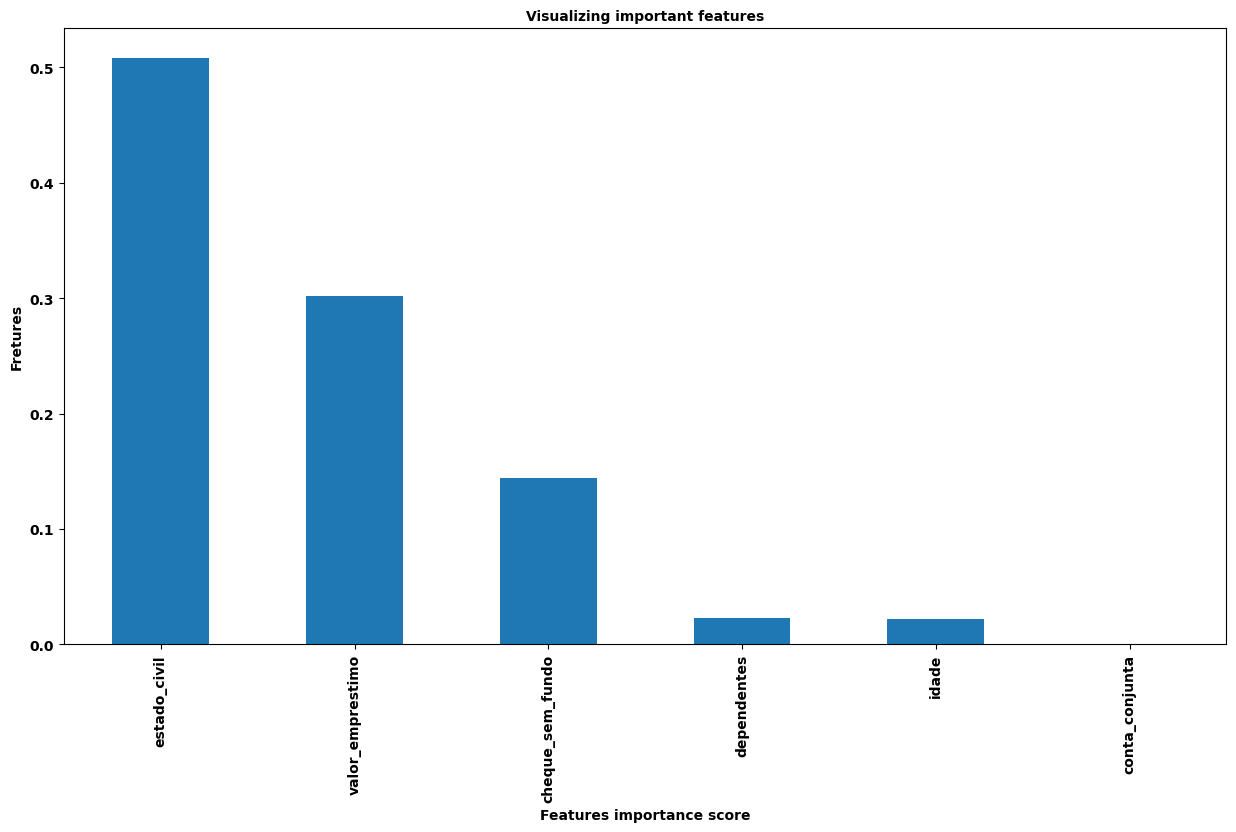

In [108]:
estimator = DecisionTreeClassifier(class_weight='balanced', random_state=config['split']['seed'], max_depth=5).fit(x_train, y_train)

features = pd.Series(estimator.feature_importances_)
features.index = x_train.columns

features.sort_values(ascending=False, inplace=True)

features.plot.bar(figsize=(15,8))

plt.xlabel('Features importance score', fontsize=10, weight='bold')
plt.ylabel('Fretures', fontsize=10, weight='bold')

plt.title('Visualizing important features', fontsize=10, weight='bold')

plt.xticks(fontsize=10, weight='bold')
plt.yticks(fontsize=10, weight='bold')

plt.show()


## 9.3 RANDOM FLOREST

### 9.3.1 RECURSIVE FEATURE ADDITION

In [109]:
columns_select = ['dependentes', 'estado_civil', 'idade', 'conta_conjunta', 'cheque_sem_fundo', 'valor_emprestimo', 'pago']

df9_rf = df9[columns_select].copy()

In [110]:
x_train, x_test, y_train, y_test = train_test_split(df9_rf.drop(['pago'], axis='columns'), df9_rf['pago'], test_size=config['split']['teste_size'], random_state=config['split']['seed'], stratify=df9_rf['pago'])


In [111]:

ce_rare = RareLabelEncoder(n_categories=5, tol=0.05, variables=['estado_civil'], replace_with='outros')
ce_rare.fit(x_train)

x_train = ce_rare.transform(x_train)
x_test = ce_rare.transform(x_test)

ce_mean = MeanEncoder(variables=['conta_conjunta', 'dependentes', 'estado_civil', 'cheque_sem_fundo']).fit(x_train, y_train)

x_train = ce_mean.transform(x_train)
x_test = ce_mean.transform(x_test)

In [112]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=config['split']['seed'])

estimator = RandomForestClassifier(class_weight='balanced', random_state=config['split']['seed'], max_depth=5)
rfa = RecursiveFeatureAddition(estimator, scoring='roc_auc', cv=kf, threshold=0.05, confirm_variables=False)
rfa.fit_transform(x_train,y_train)

,estado_civil,valor_emprestimo
38633,0.114152,10946.00
15255,0.114152,2898.91
22547,0.231518,1501.00
14271,0.114152,3169.21
29288,0.114152,7989.45
...,...,...
852,0.114152,1569.00
27337,0.114152,2630.11
19111,0.231518,54697.40
37121,0.114152,1866.15


### 9.3.2 FEATURE IMPORTANCE

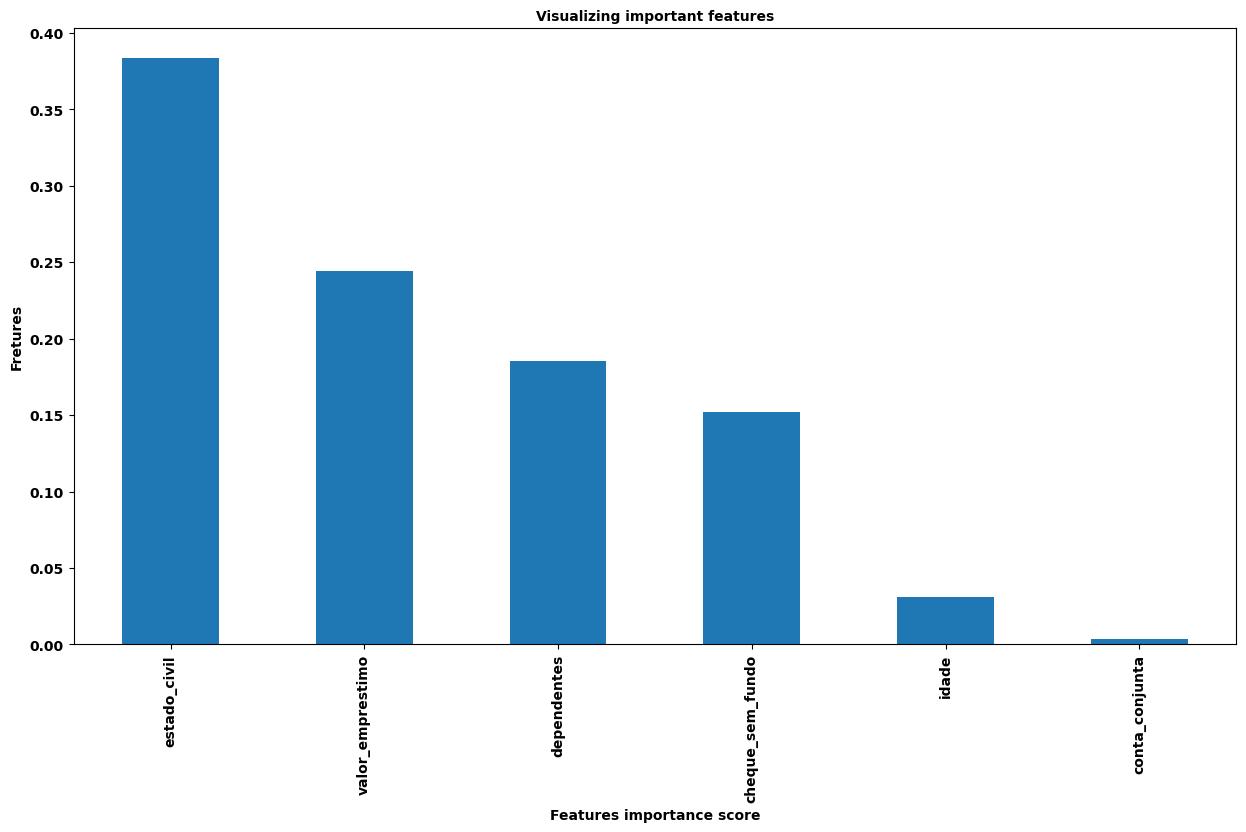

In [113]:
estimator = RandomForestClassifier(class_weight='balanced', random_state=config['split']['seed'], max_depth=5).fit(x_train, y_train)

features = pd.Series(estimator.feature_importances_)
features.index = x_train.columns

features.sort_values(ascending=False, inplace=True)

features.plot.bar(figsize=(15,8))

plt.xlabel('Features importance score', fontsize=10, weight='bold')
plt.ylabel('Fretures', fontsize=10, weight='bold')

plt.title('Visualizing important features', fontsize=10, weight='bold')

plt.xticks(fontsize=10, weight='bold')
plt.yticks(fontsize=10, weight='bold')

plt.show()


# 10.0 PIPELINE ML AND EVALUATION MODEL

## 10.1 LOGISTIC REGRESSION

In [114]:
df10_lr = pd.read_csv(config['data']['train_path'])

columns_select = ['dependentes', 'estado_civil', 'cheque_sem_fundo', 'valor_emprestimo', 'pago']

df10_lr = df10_lr[columns_select].copy()

### 10.1.1 PIPILINE

In [115]:
onehot_features = ['dependentes', 'cheque_sem_fundo', 'estado_civil']
onehot_encoder = OneHotEncoder(drop_last=True)

target_features = []
target_encoder = MeanEncoder()

std_features = []
std_encoder = StandardScaler()

rare_label = RareLabelEncoder(n_categories=5, tol=0.05, variables=['estado_civil'], replace_with='outros')

yj_features = ['valor_emprestimo']
yj_scaler = PowerTransformer(method='yeo-johnson', standardize=True)

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot_endcoder',onehot_encoder, onehot_features),
        ('target_endcoder',target_encoder, target_features),
        ('std_scaler',std_encoder, std_features),
        ('yj_scaler', yj_scaler, yj_features)
    ]
)

clf = Pipeline(
    steps=[
        ('rare_label',rare_label ),
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(n_jobs=-1,random_state=config['split']['seed'],class_weight='balanced'))
    ]
)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=config['split']['seed'])


### 10.1.2 TRAIN AND VALIDATION METRICS

In [116]:
lr_result = cv_clf_metrics(model=clf, df=df10_lr, target='pago', cv=kf, model_name='lr', search=False)

TRAIN DATA
accuracy: [0.683, 0.696, 0.694, 0.683, 0.684] / media: 0.688 / std: 0.006
balanced_accuracy: [0.687, 0.688, 0.687, 0.688, 0.686] / media: 0.687 / std: 0.001
roc_auc: [0.747, 0.746, 0.745, 0.745, 0.745] / media: 0.746 / std: 0.001
f1_class_0: [0.772, 0.784, 0.782, 0.772, 0.773] / media: 0.777 / std: 0.005
f1_class_1: [0.483, 0.486, 0.484, 0.483, 0.482] / media: 0.484 / std: 0.001
precision_class_0: [0.892, 0.889, 0.888, 0.892, 0.89] / media: 0.89 / std: 0.002
precision_class_1: [0.37, 0.38, 0.378, 0.37, 0.371] / media: 0.374 / std: 0.004
recall_class_0: [0.68, 0.702, 0.699, 0.68, 0.683] / media: 0.689 / std: 0.01
recall_class_1: [0.694, 0.675, 0.676, 0.696, 0.689] / media: 0.686 / std: 0.009

-----------------------------------------------------------------

TEST DATA
accuracy: [0.689, 0.688, 0.699, 0.675, 0.685] / media: 0.687 / std: 0.008
balanced_accuracy: [0.686, 0.677, 0.689, 0.686, 0.691] / media: 0.686 / std: 0.005
roc_auc: [0.741, 0.745, 0.746, 0.746, 0.749] / media: 

,Model Name,Accuracy CV,balanced_accuracy CV,Roc Auc Score CV,Precision Class 0 CV,Precision Class 1 CV,Recall Class 0 CV,Recall Class 1 CV,F1 Class 0 CV,F1 Class 1 CV
0,lr,0.687+/-0.008,0.686+/-0.005,0.745+/-0.003,0.889+/-0.004,0.373+/-0.006,0.688+/-0.014,0.684+/-0.019,0.776+/-0.008,0.482+/-0.005


### 10.1.3 GRID_SEARCH

In [117]:
param_grid = {
    'classifier__C':np.logspace(-3, 3, 7),
    'classifier__penalty': ['l1','l2', 'elasticnet', None],
    'classifier__class_weight': ['balanced'],
    'classifier__solver': ['saga', 'liblinear', 'lbfgs']
}

In [ ]:
lr = GridSearchCV(clf, param_grid, scoring=['f1', 'balanced_accuracy', 'roc_auc', 'accuracy'], cv=kf, refit='roc_auc')
search_lr = lr.fit(df10_lr.drop('pago', axis='columns'), df10_lr['pago'])
print(search_lr.best_params_)
print('\n')
print(round(search_lr.best_score_,3))


In [ ]:
results = pd.DataFrame(search_lr.cv_results_) [['params', 'mean_test_roc_auc', 'std_test_roc_auc', 'mean_test_f1', 'std_test_f1', 
                                               'mean_test_balanced_accuracy', 'std_test_balanced_accuracy','mean_test_accuracy', 'std_test_accuracy']]

results.sort_values(by='mean_test_roc_auc', ascending=False, inplace=True)
results.head()

,params,mean_test_roc_auc,std_test_roc_auc,mean_test_f1,std_test_f1,mean_test_balanced_accuracy,std_test_balanced_accuracy,mean_test_accuracy,std_test_accuracy
29,"{'classifier__C': 0.1, 'classifier__class_weig...",0.745303,0.002502,0.482325,0.004726,0.686194,0.004463,0.687017,0.007633
28,"{'classifier__C': 0.1, 'classifier__class_weig...",0.745284,0.002504,0.482585,0.004851,0.686458,0.004621,0.687017,0.007644
53,"{'classifier__C': 10.0, 'classifier__class_wei...",0.745274,0.002509,0.481904,0.005133,0.685781,0.004842,0.686992,0.007758
83,"{'classifier__C': 1000.0, 'classifier__class_w...",0.745274,0.002509,0.481904,0.005133,0.685781,0.004842,0.686992,0.007758
71,"{'classifier__C': 100.0, 'classifier__class_we...",0.745274,0.002509,0.481904,0.005133,0.685781,0.004842,0.686992,0.007758


(array([0.71 , 0.715, 0.72 , 0.725, 0.73 , 0.735, 0.74 , 0.745, 0.75 ]),
 [Text(0, 0.71, '0.710'),
  Text(0, 0.715, '0.715'),
  Text(0, 0.72, '0.720'),
  Text(0, 0.725, '0.725'),
  Text(0, 0.73, '0.730'),
  Text(0, 0.735, '0.735'),
  Text(0, 0.74, '0.740'),
  Text(0, 0.745, '0.745'),
  Text(0, 0.75, '0.750')])

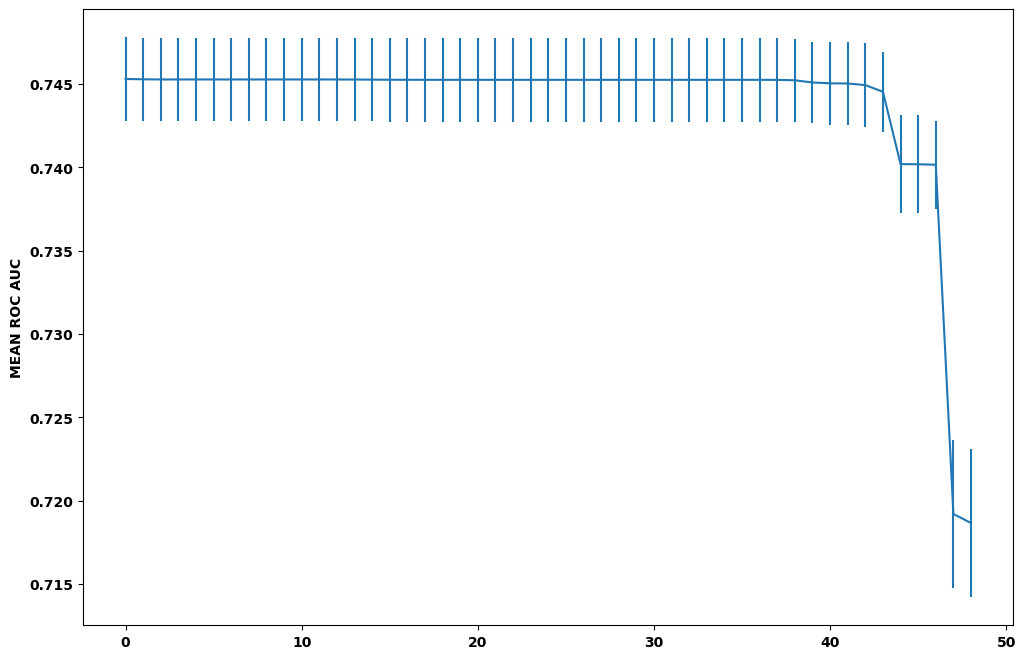

In [ ]:
results.sort_values(by='mean_test_roc_auc', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True) 

results['mean_test_roc_auc'].plot(yerr=[results['std_test_roc_auc'], results['std_test_roc_auc']], subplots=True)
plt.ylabel('MEAN ROC AUC', fontsize=10, weight='bold')
plt.xticks(fontsize=10, weight='bold')
plt.yticks(fontsize=10, weight='bold')



### 10.1.4 EVAL BEST LR MODEL

In [ ]:
search_lr.best_estimator_

Pipeline(steps=[('rare_label',
                 RareLabelEncoder(n_categories=5, replace_with='outros',
                                  variables=['estado_civil'])),
                ('preprocessor',
                 ColumnTransformer(transformers=[('onehot_endcoder',
                                                  OneHotEncoder(drop_last=True),
                                                  ['dependentes',
                                                   'cheque_sem_fundo',
                                                   'estado_civil']),
                                                 ('target_endcoder',
                                                  MeanEncoder(), []),
                                                 ('std_scaler',
                                                  StandardScaler(), []),
                                                 ('yj_scaler',
                                                  PowerTransformer(),
                                                  ['valor_emprestimo'])])),
                ('classifier',
                 LogisticRegression(C=0.1, class_weight='balanced', n_jobs=-1,
                                    random_state=42))])

In [ ]:
lr_result = cv_clf_metrics(model=search_lr.best_estimator_, df=df10_lr, target='pago', cv=kf, model_name='lr', search=False)

TRAIN DATA
accuracy: [0.683, 0.696, 0.693, 0.683, 0.685] / media: 0.688 / std: 0.005
balanced_accuracy: [0.687, 0.688, 0.687, 0.688, 0.687] / media: 0.687 / std: 0.0
roc_auc: [0.747, 0.746, 0.745, 0.745, 0.745] / media: 0.746 / std: 0.001
f1_class_0: [0.771, 0.784, 0.782, 0.771, 0.773] / media: 0.776 / std: 0.006
f1_class_1: [0.483, 0.486, 0.484, 0.483, 0.483] / media: 0.484 / std: 0.001
precision_class_0: [0.892, 0.889, 0.889, 0.892, 0.891] / media: 0.891 / std: 0.001
precision_class_1: [0.37, 0.38, 0.377, 0.37, 0.371] / media: 0.374 / std: 0.004
recall_class_0: [0.68, 0.701, 0.698, 0.68, 0.683] / media: 0.688 / std: 0.009
recall_class_1: [0.695, 0.675, 0.676, 0.696, 0.691] / media: 0.687 / std: 0.009

-----------------------------------------------------------------

TEST DATA
accuracy: [0.689, 0.688, 0.698, 0.675, 0.685] / media: 0.687 / std: 0.007
balanced_accuracy: [0.687, 0.678, 0.689, 0.686, 0.691] / media: 0.686 / std: 0.004
roc_auc: [0.741, 0.745, 0.746, 0.746, 0.749] / media:

,Model Name,Accuracy CV,balanced_accuracy CV,Roc Auc Score CV,Precision Class 0 CV,Precision Class 1 CV,Recall Class 0 CV,Recall Class 1 CV,F1 Class 0 CV,F1 Class 1 CV
0,lr,0.687+/-0.007,0.686+/-0.004,0.745+/-0.003,0.89+/-0.004,0.372+/-0.006,0.688+/-0.013,0.685+/-0.018,0.776+/-0.008,0.482+/-0.005


### 10.1.5 TEST SET METRICS

In [ ]:
test_set = pd.read_csv(config['data']['test_path'])
test_set = test_set[df10_lr.columns]
x_test = test_set.drop('pago', axis='columns')
y_test = test_set['pago']

     Predito     0     1   All
Real                          
0             5259  2387  7646
1              595  1473  2068
All           5854  3860  9714



              precision    recall  f1-score   support

           0       0.90      0.69      0.78      7646
           1       0.38      0.71      0.50      2068

    accuracy                           0.69      9714
   macro avg       0.64      0.70      0.64      9714
weighted avg       0.79      0.69      0.72      9714



ROC_AUC 0.76


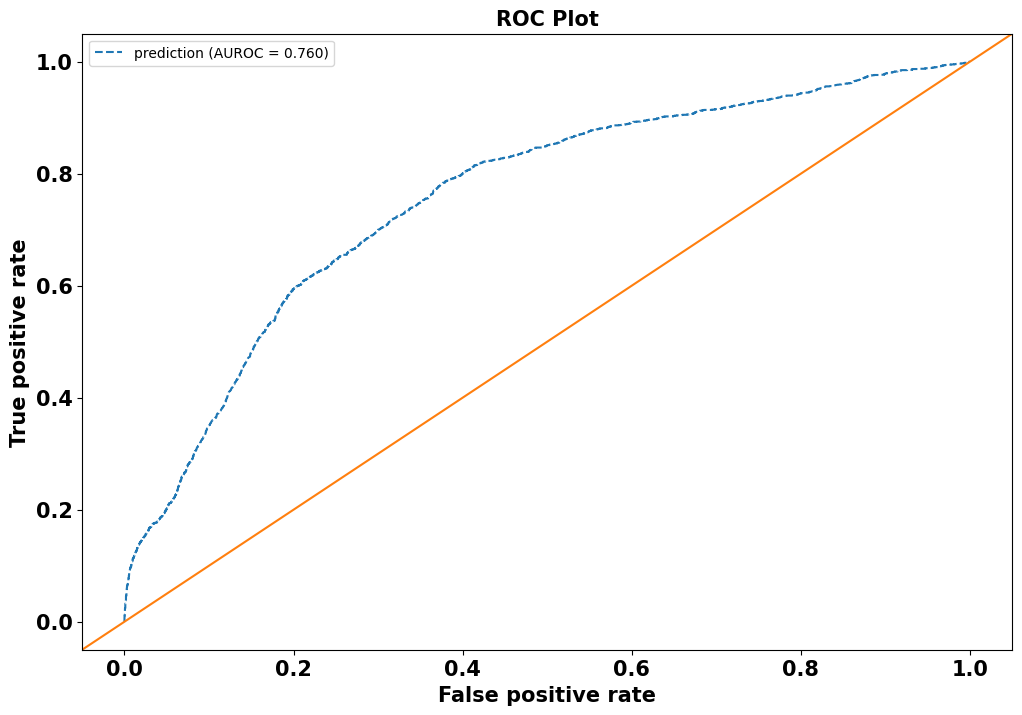

     Predito     0     1   All
Real                          
0             5745  1901  7646
1              732  1336  2068
All           6477  3237  9714



              precision    recall  f1-score   support

           0       0.89      0.75      0.81      7646
           1       0.41      0.65      0.50      2068

    accuracy                           0.73      9714
   macro avg       0.65      0.70      0.66      9714
weighted avg       0.79      0.73      0.75      9714





In [ ]:
cm_roc_plot(search_lr.best_estimator_, x_test, y_test, th=0.55)

## 10.2 DECISION TREE

In [119]:
df10_dt = pd.read_csv(config['data']['train_path'])

columns_select = ['dependentes', 'estado_civil', 'cheque_sem_fundo', 'valor_emprestimo', 'pago']

df10_dt = df10_dt[columns_select].copy()

### 10.2.1 PIPELINE

In [120]:
clf = Pipeline([
    ('rare_encoder', RareLabelEncoder(tol=0.05, n_categories=5, variables=['estado_civil'], replace_with='outros')),
    ('categorical_encoder',MeanEncoder(variables=['dependentes', 'estado_civil', 'cheque_sem_fundo'])),
    ('classifier', DecisionTreeClassifier(class_weight='balanced', random_state=config['split']['seed'], max_depth=5))
])

kf = StratifiedKFold(n_splits=5,shuffle=True, random_state=config['split']['seed'])

### 10.2.2 TRAIN AND VALIDATION METRICS

In [121]:
dt_result = cv_clf_metrics(model=clf, df=df10_dt, target='pago', cv=kf, model_name='dt', search=False)

TRAIN DATA
accuracy: [0.673, 0.745, 0.736, 0.744, 0.726] / media: 0.725 / std: 0.027
balanced_accuracy: [0.705, 0.705, 0.705, 0.703, 0.703] / media: 0.704 / std: 0.001
roc_auc: [0.772, 0.769, 0.769, 0.768, 0.769] / media: 0.769 / std: 0.001
f1_class_0: [0.758, 0.827, 0.819, 0.826, 0.81] / media: 0.808 / std: 0.026
f1_class_1: [0.498, 0.515, 0.512, 0.512, 0.508] / media: 0.509 / std: 0.006
precision_class_0: [0.909, 0.887, 0.889, 0.886, 0.891] / media: 0.892 / std: 0.008
precision_class_1: [0.37, 0.433, 0.422, 0.431, 0.411] / media: 0.413 / std: 0.023
recall_class_0: [0.65, 0.775, 0.759, 0.774, 0.743] / media: 0.74 / std: 0.047
recall_class_1: [0.76, 0.636, 0.651, 0.633, 0.663] / media: 0.669 / std: 0.047

-----------------------------------------------------------------

TEST DATA
accuracy: [0.671, 0.74, 0.735, 0.74, 0.721] / media: 0.721 / std: 0.026
balanced_accuracy: [0.692, 0.699, 0.699, 0.705, 0.701] / media: 0.699 / std: 0.004
roc_auc: [0.753, 0.766, 0.766, 0.766, 0.767] / media:

,Model Name,Accuracy CV,balanced_accuracy CV,Roc Auc Score CV,Precision Class 0 CV,Precision Class 1 CV,Recall Class 0 CV,Recall Class 1 CV,F1 Class 0 CV,F1 Class 1 CV
0,dt,0.721+/-0.026,0.699+/-0.004,0.764+/-0.005,0.89+/-0.005,0.408+/-0.024,0.738+/-0.043,0.661+/-0.036,0.806+/-0.025,0.503+/-0.01


### 10.2.3 GRID SEARCH 

In [122]:
param_grid = {
    'classifier__max_features':['auto', 'sqrt', 'log2'],
    'classifier__class_weight': ['balanced'],
    'classifier__min_samples_leaf': [100, 200, 300, 400],
    'classifier__min_samples_split': [100, 200, 300, 400],
    'classifier__max_depth': [3, 4, 5, 6, 7],
}

In [ ]:
dt = GridSearchCV(clf, param_grid, scoring=['f1', 'balanced_accuracy', 'roc_auc', 'accuracy'], cv=kf, refit='roc_auc')
search_dt = dt.fit(df10_dt.drop('pago', axis='columns'), df10_dt['pago'])
print(search_dt.best_params_)
print('\n')
print(round(search_dt.best_score_,3))


{'classifier__class_weight': 'balanced', 'classifier__max_depth': 6, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 100, 'classifier__min_samples_split': 400}


0.766


In [ ]:
results = pd.DataFrame(search_dt.cv_results_) [['params', 'mean_test_roc_auc', 'std_test_roc_auc', 'mean_test_f1', 'std_test_f1', 
                                               'mean_test_balanced_accuracy', 'std_test_balanced_accuracy','mean_test_accuracy', 'std_test_accuracy']]

results.sort_values(by='mean_test_roc_auc', ascending=False, inplace=True)
results.head()

,params,mean_test_roc_auc,std_test_roc_auc,mean_test_f1,std_test_f1,mean_test_balanced_accuracy,std_test_balanced_accuracy,mean_test_accuracy,std_test_accuracy
163,"{'classifier__class_weight': 'balanced', 'clas...",0.765881,0.005549,0.505072,0.011163,0.701677,0.006378,0.718960,0.025646
179,"{'classifier__class_weight': 'balanced', 'clas...",0.765881,0.005549,0.505072,0.011163,0.701677,0.006378,0.718960,0.025646
178,"{'classifier__class_weight': 'balanced', 'clas...",0.765414,0.004845,0.503248,0.007747,0.701471,0.003684,0.713014,0.024109
162,"{'classifier__class_weight': 'balanced', 'clas...",0.765414,0.004845,0.503248,0.007747,0.701471,0.003684,0.713014,0.024109
164,"{'classifier__class_weight': 'balanced', 'clas...",0.764742,0.005505,0.508544,0.011782,0.703480,0.006413,0.725266,0.025948


(array([0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78]),
 [Text(0, 0.72, '0.72'),
  Text(0, 0.73, '0.73'),
  Text(0, 0.74, '0.74'),
  Text(0, 0.75, '0.75'),
  Text(0, 0.76, '0.76'),
  Text(0, 0.77, '0.77'),
  Text(0, 0.78, '0.78')])

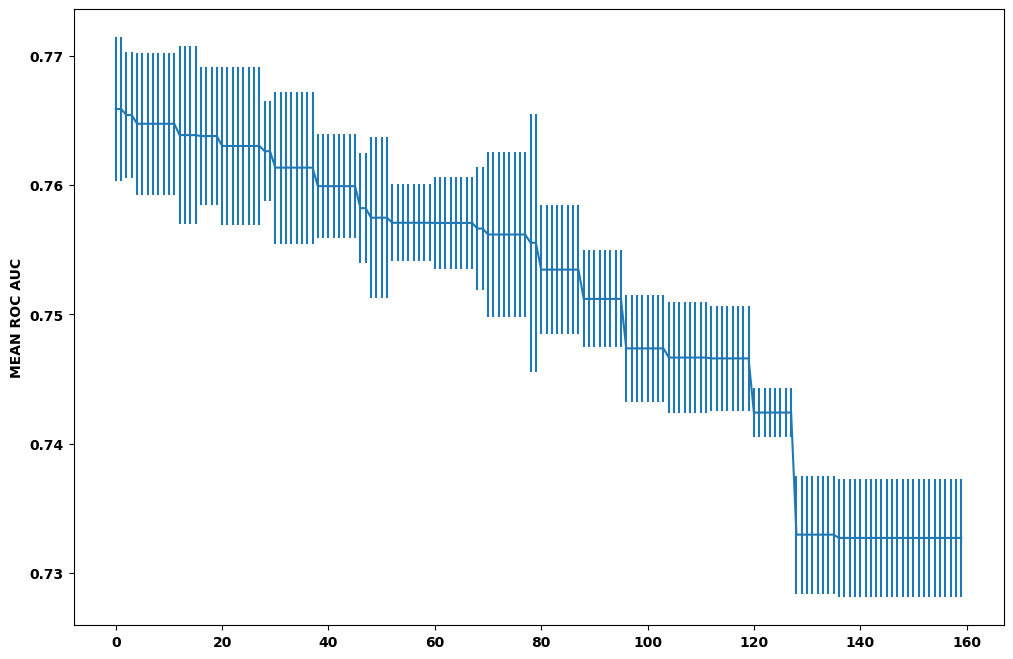

In [ ]:
results.sort_values(by='mean_test_roc_auc', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True) 

results['mean_test_roc_auc'].plot(yerr=[results['std_test_roc_auc'], results['std_test_roc_auc']], subplots=True)
plt.ylabel('MEAN ROC AUC', fontsize=10, weight='bold')
plt.xticks(fontsize=10, weight='bold')
plt.yticks(fontsize=10, weight='bold')



### 10.2.4 EVAL BEST DT MODEL

In [ ]:
search_dt.best_estimator_

Pipeline(steps=[('rare_encoder',
                 RareLabelEncoder(n_categories=5, replace_with='outros',
                                  variables=['estado_civil'])),
                ('categorical_encoder',
                 MeanEncoder(variables=['dependentes', 'estado_civil',
                                        'cheque_sem_fundo'])),
                ('classifier',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=6,
                                        max_features='sqrt',
                                        min_samples_leaf=100,
                                        min_samples_split=400,
                                        random_state=42))])

In [ ]:
dt_result = cv_clf_metrics(model=search_dt.best_estimator_, df=df10_dt, target='pago', cv=kf, model_name='dt', search=False)

TRAIN DATA
accuracy: [0.674, 0.739, 0.742, 0.737, 0.721] / media: 0.723 / std: 0.025
balanced_accuracy: [0.705, 0.709, 0.71, 0.707, 0.705] / media: 0.707 / std: 0.002
roc_auc: [0.773, 0.772, 0.773, 0.773, 0.77] / media: 0.772 / std: 0.001
f1_class_0: [0.758, 0.822, 0.824, 0.82, 0.805] / media: 0.806 / std: 0.025
f1_class_1: [0.498, 0.517, 0.519, 0.514, 0.508] / media: 0.511 / std: 0.008
precision_class_0: [0.909, 0.891, 0.891, 0.89, 0.894] / media: 0.895 / std: 0.007
precision_class_1: [0.37, 0.427, 0.43, 0.424, 0.407] / media: 0.412 / std: 0.022
recall_class_0: [0.65, 0.762, 0.766, 0.759, 0.733] / media: 0.734 / std: 0.044
recall_class_1: [0.761, 0.655, 0.653, 0.654, 0.678] / media: 0.68 / std: 0.041

-----------------------------------------------------------------

TEST DATA
accuracy: [0.67, 0.734, 0.739, 0.734, 0.718] / media: 0.719 / std: 0.026
balanced_accuracy: [0.691, 0.702, 0.701, 0.71, 0.704] / media: 0.702 / std: 0.006
roc_auc: [0.755, 0.769, 0.766, 0.772, 0.768] / media: 0.

,Model Name,Accuracy CV,balanced_accuracy CV,Roc Auc Score CV,Precision Class 0 CV,Precision Class 1 CV,Recall Class 0 CV,Recall Class 1 CV,F1 Class 0 CV,F1 Class 1 CV
0,dt,0.719+/-0.026,0.702+/-0.006,0.766+/-0.006,0.892+/-0.005,0.406+/-0.023,0.732+/-0.041,0.672+/-0.032,0.803+/-0.024,0.505+/-0.011


### 10.2.5 TEST SET METRICS

In [ ]:
test_set = pd.read_csv(config['data']['test_path'])
test_set = test_set[df10_dt.columns]
x_test = test_set.drop('pago', axis='columns')
y_test = test_set['pago']

     Predito     0     1   All
Real                          
0             5630  2016  7646
1              663  1405  2068
All           6293  3421  9714



              precision    recall  f1-score   support

           0       0.89      0.74      0.81      7646
           1       0.41      0.68      0.51      2068

    accuracy                           0.72      9714
   macro avg       0.65      0.71      0.66      9714
weighted avg       0.79      0.72      0.74      9714



ROC_AUC 0.77


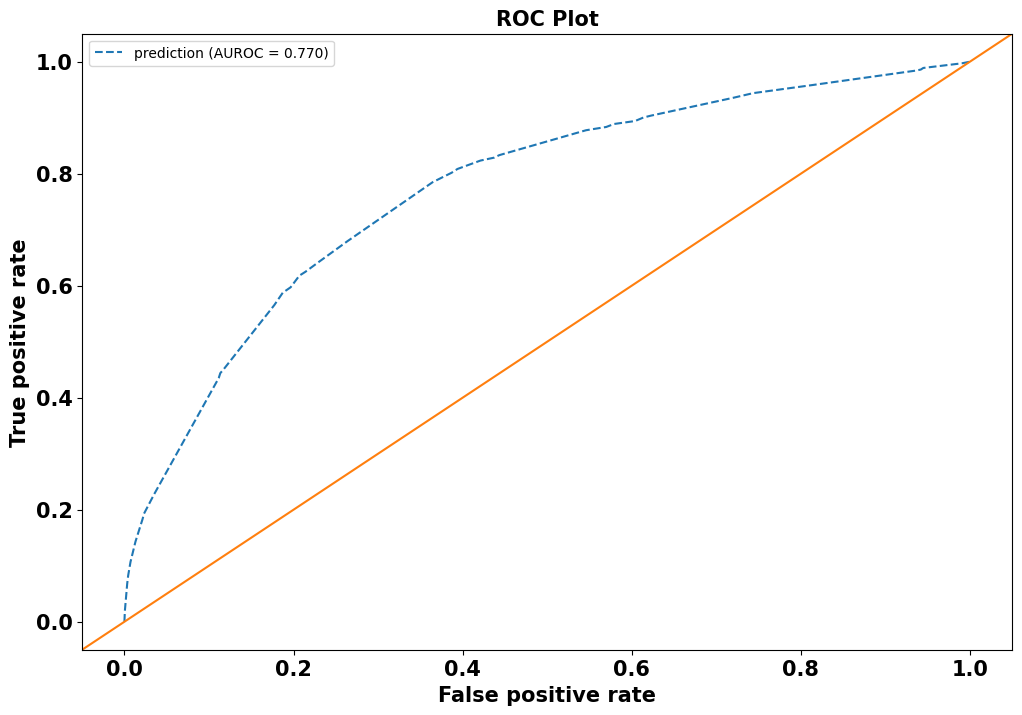

     Predito     0     1   All
Real                          
0             6010  1636  7646
1              776  1292  2068
All           6786  2928  9714



              precision    recall  f1-score   support

           0       0.89      0.79      0.83      7646
           1       0.44      0.62      0.52      2068

    accuracy                           0.75      9714
   macro avg       0.66      0.71      0.68      9714
weighted avg       0.79      0.75      0.77      9714





In [ ]:
cm_roc_plot(search_dt.best_estimator_, x_test, y_test, th=0.55)

## 10.3 RANDOM FLOREST

In [123]:
df10_rf = pd.read_csv(config['data']['train_path'])

columns_select = ['dependentes', 'estado_civil', 'cheque_sem_fundo', 'idade', 'valor_emprestimo', 'pago']

df10_rf = df10_rf[columns_select].copy()

### 10.3.1 PIPELINE

In [124]:
clf = Pipeline([
    ('rare_encoder', RareLabelEncoder(tol=0.05, n_categories=5, variables=['estado_civil'], replace_with='outros')),
    ('categorical_encoder',MeanEncoder(variables=['dependentes', 'estado_civil', 'cheque_sem_fundo'])),
    ('classifier', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=config['split']['seed'], max_depth=5, max_features='sqrt', n_jobs=-1))
])

kf = StratifiedKFold(n_splits=5,shuffle=True, random_state=config['split']['seed'])

### 10.3.2 TRAIN AND VALIDATION METRICS

In [ ]:
rf_result = cv_clf_metrics(model=clf, df=df10_rf, target='pago', cv=kf, model_name='rf', search=False)

TRAIN DATA
accuracy: [0.687, 0.705, 0.714, 0.686, 0.684] / media: 0.695 / std: 0.012
balanced_accuracy: [0.714, 0.716, 0.718, 0.71, 0.709] / media: 0.713 / std: 0.003
roc_auc: [0.784, 0.78, 0.781, 0.781, 0.779] / media: 0.781 / std: 0.002
f1_class_0: [0.771, 0.788, 0.797, 0.77, 0.768] / media: 0.779 / std: 0.012
f1_class_1: [0.509, 0.515, 0.519, 0.505, 0.503] / media: 0.51 / std: 0.006
precision_class_0: [0.912, 0.906, 0.905, 0.908, 0.909] / media: 0.908 / std: 0.002
precision_class_1: [0.382, 0.396, 0.405, 0.38, 0.378] / media: 0.388 / std: 0.011
recall_class_0: [0.668, 0.698, 0.712, 0.668, 0.665] / media: 0.682 / std: 0.019
recall_class_1: [0.761, 0.734, 0.724, 0.751, 0.752] / media: 0.744 / std: 0.013

-----------------------------------------------------------------

TEST DATA
accuracy: [0.682, 0.702, 0.709, 0.677, 0.688] / media: 0.692 / std: 0.012
balanced_accuracy: [0.696, 0.714, 0.706, 0.706, 0.714] / media: 0.707 / std: 0.007
roc_auc: [0.765, 0.776, 0.777, 0.777, 0.781] / medi

,Model Name,Accuracy CV,balanced_accuracy CV,Roc Auc Score CV,Precision Class 0 CV,Precision Class 1 CV,Recall Class 0 CV,Recall Class 1 CV,F1 Class 0 CV,F1 Class 1 CV
0,rf,0.692+/-0.012,0.707+/-0.007,0.775+/-0.005,0.905+/-0.005,0.384+/-0.01,0.68+/-0.02,0.735+/-0.022,0.776+/-0.011,0.504+/-0.008


### 10.3.3 RANDOM SEARCH

In [ ]:
param_grid = {
    'classifier__n_estimators': [150,200],
    'classifier__max_features':['auto', 'sqrt'],
    'classifier__class_weight': ['balanced'],
    'classifier__min_samples_leaf': [100, 200, 300],
    'classifier__min_samples_split': [100, 200, 300],
    'classifier__max_depth': [6, 7, 8],
}

In [ ]:
rf = RandomizedSearchCV(clf, param_grid, scoring=['f1', 'balanced_accuracy', 'roc_auc', 'accuracy'], cv=kf, refit='roc_auc', random_state=config['split']['seed'], n_iter=60)
search_rf = rf.fit(df10_rf.drop('pago', axis='columns'), df10_rf['pago'])
print(search_rf.best_params_)
print('\n')
print(round(search_rf.best_score_,3))


{'classifier__n_estimators': 150, 'classifier__min_samples_split': 100, 'classifier__min_samples_leaf': 100, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 8, 'classifier__class_weight': 'balanced'}


0.778


In [ ]:
results = pd.DataFrame(search_rf.cv_results_) [['params', 'mean_test_roc_auc', 'std_test_roc_auc', 'mean_test_f1', 'std_test_f1', 
                                               'mean_test_balanced_accuracy', 'std_test_balanced_accuracy','mean_test_accuracy', 'std_test_accuracy']]

results.sort_values(by='mean_test_roc_auc', ascending=False, inplace=True)
results.head()

,params,mean_test_roc_auc,std_test_roc_auc,mean_test_f1,std_test_f1,mean_test_balanced_accuracy,std_test_balanced_accuracy,mean_test_accuracy,std_test_accuracy
53,"{'classifier__n_estimators': 150, 'classifier_...",0.778027,0.005190,0.515105,0.005190,0.712946,0.004728,0.717054,0.005886
8,"{'classifier__n_estimators': 200, 'classifier_...",0.777610,0.005342,0.513971,0.004180,0.712298,0.004047,0.715201,0.003069
16,"{'classifier__n_estimators': 150, 'classifier_...",0.777379,0.005225,0.515295,0.006933,0.712288,0.005357,0.719834,0.010126
34,"{'classifier__n_estimators': 200, 'classifier_...",0.777364,0.005246,0.516190,0.006597,0.712937,0.004980,0.720787,0.009915
52,"{'classifier__n_estimators': 200, 'classifier_...",0.776051,0.005312,0.513815,0.009319,0.711347,0.006980,0.717312,0.014639


(array([0.766, 0.768, 0.77 , 0.772, 0.774, 0.776, 0.778, 0.78 , 0.782,
        0.784]),
 [Text(0, 0.766, '0.766'),
  Text(0, 0.768, '0.768'),
  Text(0, 0.77, '0.770'),
  Text(0, 0.772, '0.772'),
  Text(0, 0.774, '0.774'),
  Text(0, 0.776, '0.776'),
  Text(0, 0.778, '0.778'),
  Text(0, 0.78, '0.780'),
  Text(0, 0.782, '0.782'),
  Text(0, 0.784, '0.784')])

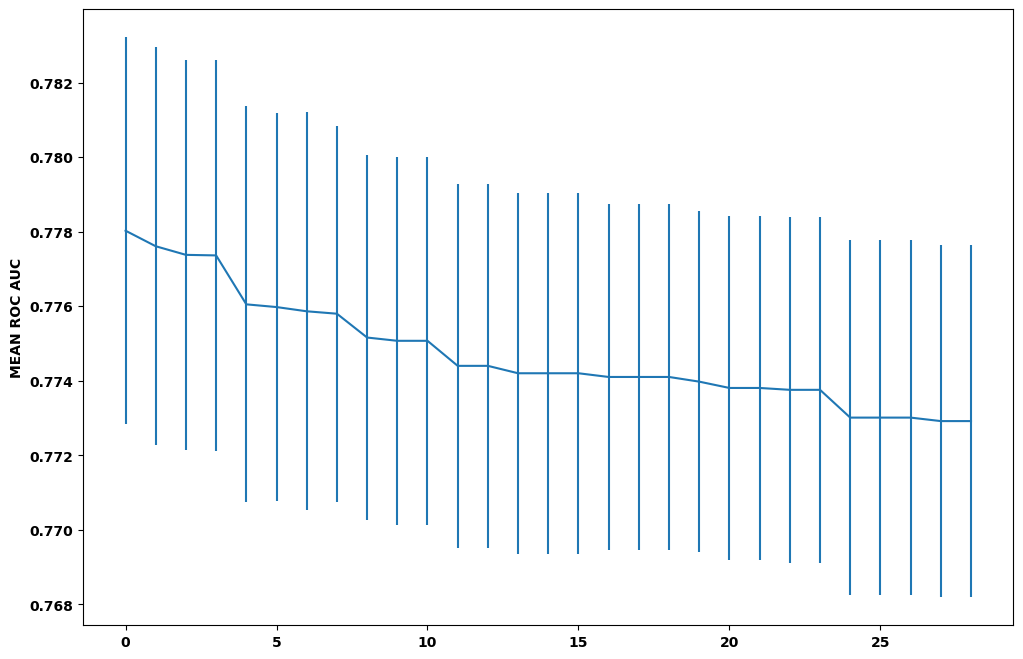

In [ ]:
results.sort_values(by='mean_test_roc_auc', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True) 

results['mean_test_roc_auc'].plot(yerr=[results['std_test_roc_auc'], results['std_test_roc_auc']], subplots=True)
plt.ylabel('MEAN ROC AUC', fontsize=10, weight='bold')
plt.xticks(fontsize=10, weight='bold')
plt.yticks(fontsize=10, weight='bold')



### 10.3.4 EVAL BEST RF MODEL

In [ ]:
search_rf.best_estimator_

Pipeline(steps=[('rare_encoder',
                 RareLabelEncoder(n_categories=5, replace_with='outros',
                                  variables=['estado_civil'])),
                ('categorical_encoder',
                 MeanEncoder(variables=['dependentes', 'estado_civil',
                                        'cheque_sem_fundo'])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=8,
                                        min_samples_leaf=100,
                                        min_samples_split=100, n_estimators=150,
                                        n_jobs=-1, random_state=42))])

In [ ]:
rf_result = cv_clf_metrics(model=search_rf.best_estimator_, df=df10_rf, target='pago', cv=kf, model_name='rf', search=False)

TRAIN DATA
accuracy: [0.716, 0.728, 0.724, 0.715, 0.721] / media: 0.721 / std: 0.005
balanced_accuracy: [0.721, 0.717, 0.72, 0.718, 0.718] / media: 0.719 / std: 0.001
roc_auc: [0.79, 0.787, 0.788, 0.787, 0.787] / media: 0.788 / std: 0.001
f1_class_0: [0.798, 0.81, 0.806, 0.797, 0.803] / media: 0.803 / std: 0.005
f1_class_1: [0.522, 0.522, 0.524, 0.519, 0.521] / media: 0.522 / std: 0.002
precision_class_0: [0.907, 0.9, 0.903, 0.905, 0.903] / media: 0.904 / std: 0.002
precision_class_1: [0.407, 0.417, 0.414, 0.405, 0.41] / media: 0.411 / std: 0.004
recall_class_0: [0.712, 0.737, 0.727, 0.713, 0.723] / media: 0.722 / std: 0.009
recall_class_1: [0.73, 0.697, 0.712, 0.722, 0.712] / media: 0.715 / std: 0.011

-----------------------------------------------------------------

TEST DATA
accuracy: [0.714, 0.727, 0.718, 0.709, 0.718] / media: 0.717 / std: 0.006
balanced_accuracy: [0.708, 0.715, 0.707, 0.715, 0.72] / media: 0.713 / std: 0.005
roc_auc: [0.768, 0.78, 0.78, 0.78, 0.783] / media: 0.7

,Model Name,Accuracy CV,balanced_accuracy CV,Roc Auc Score CV,Precision Class 0 CV,Precision Class 1 CV,Recall Class 0 CV,Recall Class 1 CV,F1 Class 0 CV,F1 Class 1 CV
0,rf,0.717+/-0.006,0.713+/-0.005,0.778+/-0.005,0.9+/-0.003,0.406+/-0.006,0.72+/-0.01,0.706+/-0.015,0.8+/-0.006,0.515+/-0.005


### 10.3.5 TEST SET METRICS

In [ ]:
test_set = pd.read_csv(config['data']['test_path'])
test_set = test_set[df10_rf.columns]
x_test = test_set.drop('pago', axis='columns')
y_test = test_set['pago']

     Predito     0     1   All
Real                          
0             5584  2062  7646
1              598  1470  2068
All           6182  3532  9714



              precision    recall  f1-score   support

           0       0.90      0.73      0.81      7646
           1       0.42      0.71      0.53      2068

    accuracy                           0.73      9714
   macro avg       0.66      0.72      0.67      9714
weighted avg       0.80      0.73      0.75      9714



ROC_AUC 0.79


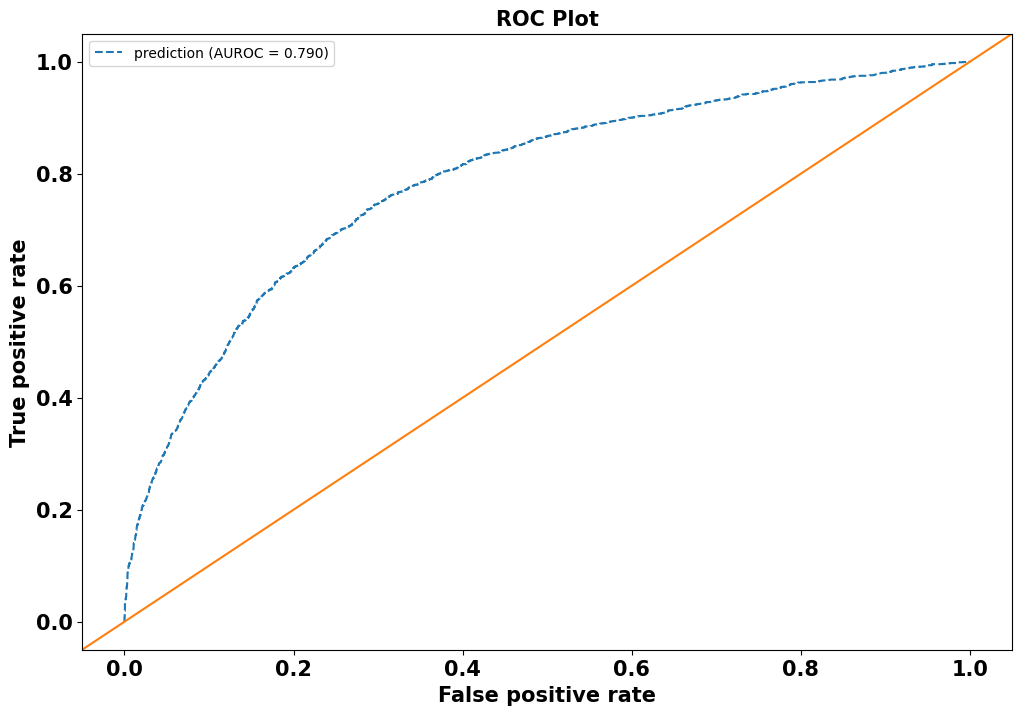

     Predito     0     1   All
Real                          
0             6055  1591  7646
1              748  1320  2068
All           6803  2911  9714



              precision    recall  f1-score   support

           0       0.89      0.79      0.84      7646
           1       0.45      0.64      0.53      2068

    accuracy                           0.76      9714
   macro avg       0.67      0.72      0.68      9714
weighted avg       0.80      0.76      0.77      9714





In [ ]:
cm_roc_plot(search_rf.best_estimator_, x_test, y_test, th=0.55)

## 10.4 XGBOOST 

In [77]:
df10_xgb = pd.read_csv(config['data']['train_path'])

columns_select = ['dependentes', 'estado_civil', 'cheque_sem_fundo', 'idade', 'valor_emprestimo', 'pago']

df10_xgb = df10_xgb[columns_select].copy()

### 10.4.1 PIPELINE

In [78]:
clf = Pipeline([
    ('rare_encoder', RareLabelEncoder(tol=0.05, n_categories=5, variables=['estado_civil'], replace_with='outros')),
    ('categorical_encoder',MeanEncoder(variables=['dependentes', 'estado_civil', 'cheque_sem_fundo'])),
    ('classifier', xgb.XGBClassifier(n_estimators=200, random_state=config['split']['seed'], scale_pos_weight=4, max_depth=3, n_jobs=-1))
])

kf = StratifiedKFold(n_splits=5,shuffle=True, random_state=config['split']['seed'])

### 10.4.2 TRAIN AND VALIDATION METRICS

In [79]:
xgb_result = cv_clf_metrics(model=clf, df=df10_xgb, target='pago', cv=kf, model_name='xgb', search=False)

TRAIN DATA
accuracy: [0.729, 0.728, 0.731, 0.727, 0.724] / media: 0.728 / std: 0.002
balanced_accuracy: [0.733, 0.732, 0.733, 0.732, 0.73] / media: 0.732 / std: 0.001
roc_auc: [0.808, 0.805, 0.806, 0.806, 0.805] / media: 0.806 / std: 0.001
f1_class_0: [0.809, 0.807, 0.81, 0.807, 0.804] / media: 0.807 / std: 0.002
f1_class_1: [0.538, 0.537, 0.538, 0.536, 0.534] / media: 0.537 / std: 0.001
precision_class_0: [0.912, 0.912, 0.911, 0.911, 0.911] / media: 0.911 / std: 0.0
precision_class_1: [0.423, 0.421, 0.424, 0.42, 0.417] / media: 0.421 / std: 0.002
recall_class_0: [0.727, 0.725, 0.729, 0.724, 0.72] / media: 0.725 / std: 0.003
recall_class_1: [0.74, 0.74, 0.738, 0.739, 0.74] / media: 0.739 / std: 0.001

-----------------------------------------------------------------

TEST DATA
accuracy: [0.716, 0.715, 0.717, 0.711, 0.712] / media: 0.714 / std: 0.002
balanced_accuracy: [0.705, 0.713, 0.708, 0.715, 0.718] / media: 0.712 / std: 0.005
roc_auc: [0.766, 0.776, 0.778, 0.781, 0.78] / media: 0.

,Model Name,Accuracy CV,balanced_accuracy CV,Roc Auc Score CV,Precision Class 0 CV,Precision Class 1 CV,Recall Class 0 CV,Recall Class 1 CV,F1 Class 0 CV,F1 Class 1 CV
0,xgb,0.714+/-0.002,0.712+/-0.005,0.776+/-0.005,0.901+/-0.004,0.403+/-0.001,0.716+/-0.007,0.707+/-0.016,0.798+/-0.003,0.513+/-0.004


### 10.4.3 RANDOM SEARCH

In [80]:
param_grid = {
    'classifier__n_estimators': [100,150,200],
    'classifier__eta':[0.01,0.03,0.05],
    'classifier__scale_pos_weight': [4],
    'classifier__subsample': [0.3, 0.5, 0.7],
    'classifier__colsample_bytree': [0.3, 0.5, 0.7],
    'classifier__max_depth': [6, 7, 8],
    'classifier__min_child_weight': [3, 7, 10, 15],
    'classifier__alpha': [0.01, 0.1, 0.3],
    'classifier__lambda': [0.01, 0.1, 0.3]
}

In [81]:
xgb = RandomizedSearchCV(clf, param_grid, scoring=['f1', 'balanced_accuracy', 'roc_auc', 'accuracy'], cv=kf, refit='roc_auc', random_state=config['split']['seed'], n_iter=60)
search_xgb = xgb.fit(df10_xgb.drop('pago', axis='columns'), df10_xgb['pago'])
print(search_xgb.best_params_)
print('\n')
print(round(search_xgb.best_score_,3))


{'classifier__subsample': 0.5, 'classifier__scale_pos_weight': 4, 'classifier__n_estimators': 200, 'classifier__min_child_weight': 3, 'classifier__max_depth': 6, 'classifier__lambda': 0.01, 'classifier__eta': 0.03, 'classifier__colsample_bytree': 0.7, 'classifier__alpha': 0.1}


0.78


In [82]:
results = pd.DataFrame(search_xgb.cv_results_) [['params', 'mean_test_roc_auc', 'std_test_roc_auc', 'mean_test_f1', 'std_test_f1', 
                                               'mean_test_balanced_accuracy', 'std_test_balanced_accuracy','mean_test_accuracy', 'std_test_accuracy']]

results.sort_values(by='mean_test_roc_auc', ascending=False, inplace=True)
results.head()

,params,mean_test_roc_auc,std_test_roc_auc,mean_test_f1,std_test_f1,mean_test_balanced_accuracy,std_test_balanced_accuracy,mean_test_accuracy,std_test_accuracy
3,"{'classifier__subsample': 0.5, 'classifier__sc...",0.779744,0.005454,0.514607,0.004996,0.714300,0.004665,0.710234,0.003820
39,"{'classifier__subsample': 0.7, 'classifier__sc...",0.779723,0.005581,0.512225,0.005428,0.712580,0.004928,0.707248,0.005000
9,"{'classifier__subsample': 0.3, 'classifier__sc...",0.779464,0.005165,0.514082,0.004899,0.713664,0.004826,0.710620,0.002286
4,"{'classifier__subsample': 0.5, 'classifier__sc...",0.779462,0.005488,0.514648,0.005074,0.714700,0.004816,0.708921,0.005089
25,"{'classifier__subsample': 0.7, 'classifier__sc...",0.779406,0.005356,0.515542,0.004228,0.714733,0.003657,0.712164,0.004547


(array([0.75 , 0.755, 0.76 , 0.765, 0.77 , 0.775, 0.78 , 0.785, 0.79 ]),
 [Text(0, 0.75, '0.750'),
  Text(0, 0.755, '0.755'),
  Text(0, 0.76, '0.760'),
  Text(0, 0.765, '0.765'),
  Text(0, 0.77, '0.770'),
  Text(0, 0.775, '0.775'),
  Text(0, 0.78, '0.780'),
  Text(0, 0.785, '0.785'),
  Text(0, 0.79, '0.790')])

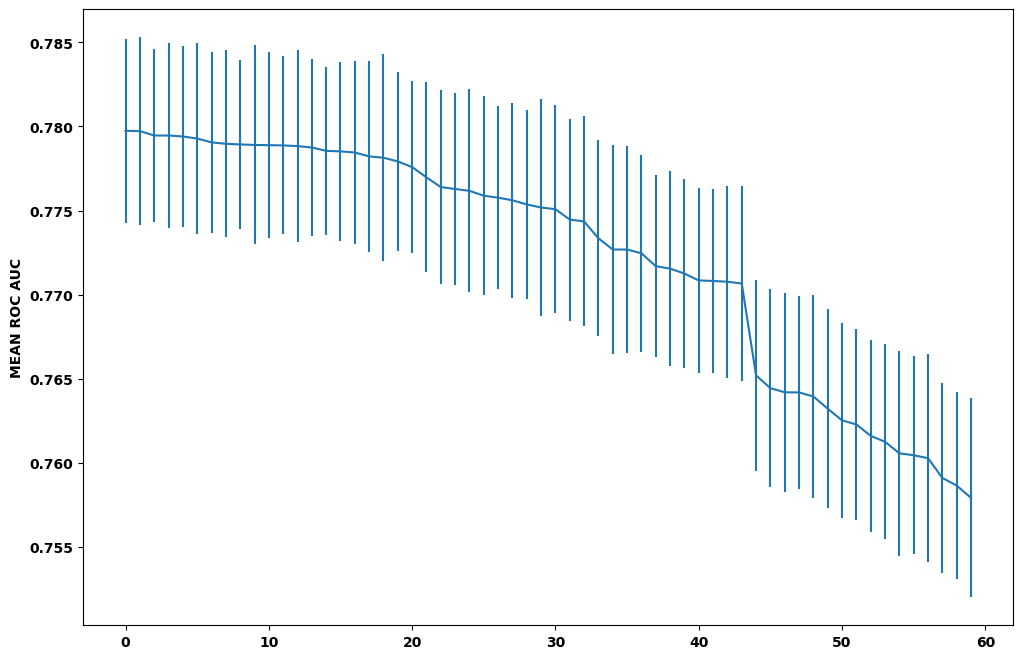

In [131]:
results.sort_values(by='mean_test_roc_auc', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True) 

results['mean_test_roc_auc'].plot(yerr=[results['std_test_roc_auc'], results['std_test_roc_auc']], subplots=True)
plt.ylabel('MEAN ROC AUC', fontsize=10, weight='bold')
plt.xticks(fontsize=10, weight='bold')
plt.yticks(fontsize=10, weight='bold')



### 10.4.4 EVAL BEST RF MODEL

In [132]:
search_xgb.best_estimator_

Pipeline(steps=[('rare_encoder',
                 RareLabelEncoder(n_categories=5, replace_with='outros',
                                  variables=['estado_civil'])),
                ('categorical_encoder',
                 MeanEncoder(variables=['dependentes', 'estado_civil',
                                        'cheque_sem_fundo'])),
                ('classifier',
                 XGBClassifier(alpha=0.1, base_score=None, booster=None,
                               callbacks=None, colsample_bylevel=None,
                               colsample_bynode=None, colsample_b...
                               eval_metric=None, feature_types=None, gamma=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, lambda=0.01,
                               learning_rate=None, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=6,
                               max_leaves=None, min_child_weight=3, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, ...))])

In [133]:
xgb_result = cv_clf_metrics(model=search_xgb.best_estimator_, df=df10_xgb, target='pago', cv=kf, model_name='xgb', search=False)

TRAIN DATA
accuracy: [0.72, 0.722, 0.725, 0.72, 0.719] / media: 0.721 / std: 0.002
balanced_accuracy: [0.733, 0.73, 0.73, 0.73, 0.729] / media: 0.73 / std: 0.001
roc_auc: [0.806, 0.803, 0.804, 0.803, 0.803] / media: 0.804 / std: 0.001
f1_class_0: [0.8, 0.802, 0.805, 0.801, 0.799] / media: 0.801 / std: 0.002
f1_class_1: [0.535, 0.532, 0.533, 0.532, 0.53] / media: 0.532 / std: 0.002
precision_class_0: [0.915, 0.912, 0.911, 0.912, 0.912] / media: 0.912 / std: 0.001
precision_class_1: [0.414, 0.415, 0.418, 0.413, 0.411] / media: 0.414 / std: 0.002
recall_class_0: [0.71, 0.717, 0.721, 0.714, 0.711] / media: 0.715 / std: 0.004
recall_class_1: [0.756, 0.743, 0.738, 0.745, 0.746] / media: 0.746 / std: 0.006

-----------------------------------------------------------------

TEST DATA
accuracy: [0.705, 0.714, 0.715, 0.71, 0.707] / media: 0.71 / std: 0.004
balanced_accuracy: [0.706, 0.719, 0.712, 0.718, 0.716] / media: 0.714 / std: 0.005
roc_auc: [0.769, 0.782, 0.783, 0.782, 0.783] / media: 0.78

,Model Name,Accuracy CV,balanced_accuracy CV,Roc Auc Score CV,Precision Class 0 CV,Precision Class 1 CV,Recall Class 0 CV,Recall Class 1 CV,F1 Class 0 CV,F1 Class 1 CV
0,xgb,0.71+/-0.004,0.714+/-0.005,0.78+/-0.005,0.904+/-0.003,0.4+/-0.004,0.707+/-0.006,0.721+/-0.011,0.793+/-0.003,0.515+/-0.005


### 10.4.5 TEST SET METRICS

In [10]:
test_set = pd.read_csv(config['data']['test_path'])
test_set = test_set[df10_xgb.columns]
x_test = test_set.drop('pago', axis='columns')
y_test = test_set['pago']

     Predito     0     1   All
Real                          
0             5458  2188  7646
1              565  1503  2068
All           6023  3691  9714



              precision    recall  f1-score   support

           0       0.91      0.71      0.80      7646
           1       0.41      0.73      0.52      2068

    accuracy                           0.72      9714
   macro avg       0.66      0.72      0.66      9714
weighted avg       0.80      0.72      0.74      9714



ROC_AUC 0.79


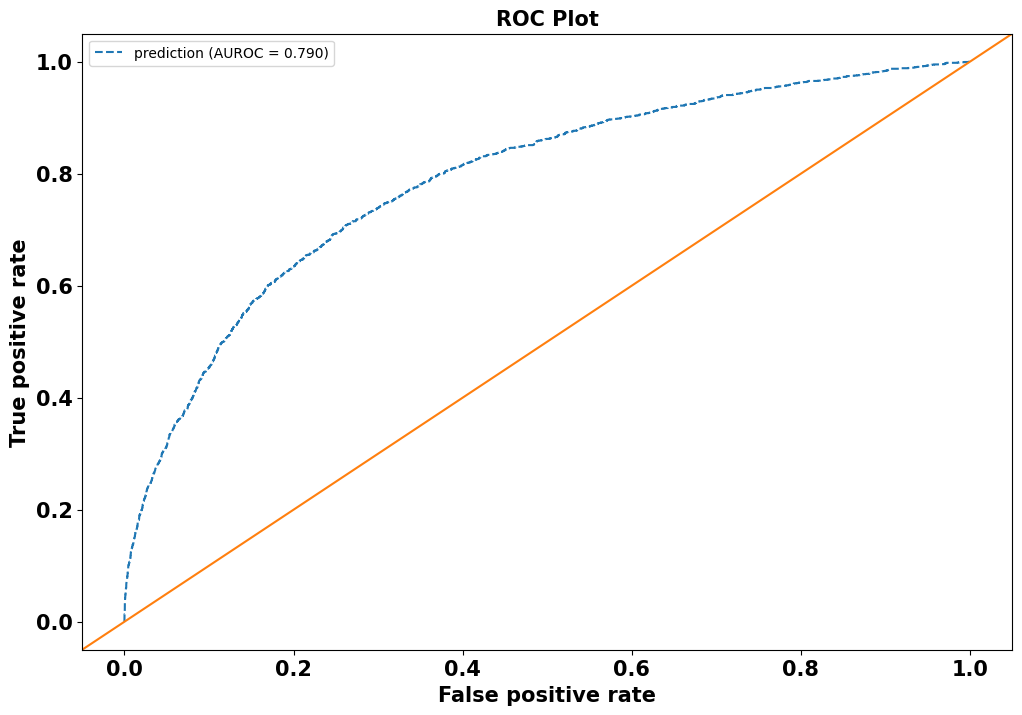

     Predito     0     1   All
Real                          
0             5915  1731  7646
1              697  1371  2068
All           6612  3102  9714



              precision    recall  f1-score   support

           0       0.89      0.77      0.83      7646
           1       0.44      0.66      0.53      2068

    accuracy                           0.75      9714
   macro avg       0.67      0.72      0.68      9714
weighted avg       0.80      0.75      0.77      9714





In [135]:
cm_roc_plot(search_xgb.best_estimator_, x_test, y_test, th=0.55)

# 11.0 COMPARE MODELS

In [136]:
train_set = pd.read_csv(config['data']['train_path'])
test_set = pd.read_csv(config['data']['test_path'])

columns_select = ['dependentes', 'estado_civil', 'cheque_sem_fundo', 'idade', 'valor_emprestimo', 'pago']

test_set = test_set[columns_select].copy()
train_set = test_set[columns_select].copy()

x_test = test_set.drop('pago', axis='columns')
y_test = test_set['pago']

x_train = train_set.drop('pago', axis='columns')
y_train = train_set['pago']

In [ ]:
XGB_prob = search_xgb.best_estimator_.predict_proba(x_test)[:,1]
LR_prob = search_lr.best_estimator_.predict_proba(x_test.drop('idade', axis='columns'))[:,1]
RF_prob = search_rf.best_estimator_.predict_proba(x_test)[:,1]
DT_prob = search_dt.best_estimator_.predict_proba(x_test.drop('idade', axis='columns'))[:,1]

XGB_auc = metrics.roc_auc_score(y_test, XGB_prob)
LR_auc = metrics.roc_auc_score(y_test, LR_prob)
RF_auc = metrics.roc_auc_score(y_test, RF_prob)
DT_auc = metrics.roc_auc_score(y_test, DT_prob)

XGB_frp, XGB_tpr, _ = metrics.roc_curve(y_test, XGB_prob)
RF_frp, RF_tpr, _ = metrics.roc_curve(y_test, RF_prob)
DT_frp, DT_tpr, _ = metrics.roc_curve(y_test, DT_prob)
LR_frp, LR_tpr, _ = metrics.roc_curve(y_test, LR_prob)


fig, ax = plt.subplots(figsize=(12,8))


plt.plot(XGB_frp, XGB_tpr, linestyle='--', label ='XGB prediction (AUROC = %0.3f)' %XGB_auc)
plt.plot(RF_frp, RF_tpr, linestyle='--', label ='RF prediction (AUROC = %0.3f)' %RF_auc)
plt.plot(DT_frp, DT_tpr, linestyle='--', label ='DT prediction (AUROC = %0.3f)' %DT_auc)
plt.plot(LR_frp, LR_tpr, linestyle='--', label ='LR prediction (AUROC = %0.3f)' %LR_auc)
ax.plot([0,1],[0,1], transform=ax.transAxes)

# Title
plt.title('ROC Plot', fontsize=15, weight='bold')

# Axis labels
plt.xticks(fontsize=15, weight='bold')
plt.yticks(fontsize=15, weight='bold')

# recall class 0 - 1 True positive rate (TP / (TP + FN))
plt.ylabel('True positive rate', fontsize=15, weight='bold')

# recall class 0 - 1 False positive rate (FP / (FP + TN))
plt.xlabel('False positive rate', fontsize=15, weight='bold')

plt.legend()

plt.show()


In [ ]:
modelling_result = pd.concat([xgb_result, rf_result, dt_result, lr_result])
modelling_result

,Model Name,Accuracy CV,balanced_accuracy CV,Roc Auc Score CV,Precision Class 0 CV,Precision Class 1 CV,Recall Class 0 CV,Recall Class 1 CV,F1 Class 0 CV,F1 Class 1 CV
0,xgb,0.71+/-0.004,0.714+/-0.005,0.78+/-0.005,0.904+/-0.003,0.4+/-0.004,0.707+/-0.006,0.721+/-0.011,0.793+/-0.003,0.515+/-0.005
0,rf,0.717+/-0.006,0.713+/-0.005,0.778+/-0.005,0.9+/-0.003,0.406+/-0.006,0.72+/-0.01,0.706+/-0.015,0.8+/-0.006,0.515+/-0.005
0,dt,0.719+/-0.026,0.702+/-0.006,0.766+/-0.006,0.892+/-0.005,0.406+/-0.023,0.732+/-0.041,0.672+/-0.032,0.803+/-0.024,0.505+/-0.011
0,lr,0.687+/-0.007,0.686+/-0.004,0.745+/-0.003,0.89+/-0.004,0.372+/-0.006,0.688+/-0.013,0.685+/-0.018,0.776+/-0.008,0.482+/-0.005


In [ ]:
result_xgb = test_metric(search_xgb.best_estimator_, x_test, y_test, 'xgb')
result_rf = test_metric(search_rf.best_estimator_, x_test, y_test, 'rf')
result_dt = test_metric(search_dt.best_estimator_, x_test.drop('idade',axis='columns'), y_test, 'dt')
result_lr = test_metric(search_lr.best_estimator_, x_test.drop('idade',axis='columns'), y_test, 'lr')

modeliing_result_test = pd.concat([result_xgb, result_rf, result_dt, result_lr])
modeliing_result_test

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,accuracy,roc_auc,balanced_accuracy,model_name
0,0.906,0.407,0.714,0.727,0.799,0.522,0.717,0.789,0.720,xgb
0,0.903,0.416,0.730,0.711,0.808,0.525,0.726,0.787,0.721,rf
0,0.895,0.411,0.736,0.679,0.808,0.512,0.724,0.773,0.708,dt
0,0.898,0.382,0.688,0.712,0.779,0.497,0.693,0.757,0.700,lr
